## Shape clean-up
The previous steps results in shapefiles per gauge, where the semi-distributed shapes do not yet take nested gauges into account. Here, we:
1. Ensure that every polygon in the shapefiles has a unique identifier (currently nested gauges within a single MERIT basin polygon all carry the same COMID)
2. Ensure that in the case of nested gauges, a more downstream gauge still has its polygon split at a more upstream gauge.

In [1]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import os
from shapely import Point
from shapely import set_precision
from shapely.ops import unary_union
import shutil
import sys
import geopandas as gpd
import pandas as pd
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
import python_cs_functions as cs

### Config handling

In [25]:
# Specify where the config file can be found
config_file = '../0_config/config.txt'

# Get the required info from the config file
data_path     = cs.read_from_config(config_file,'data_path')

# CAMELS-spat metadata
cs_meta_path  = cs.read_from_config(config_file,'cs_basin_path')
cs_meta_name  = cs.read_from_config(config_file,'cs_meta_name')
cs_unusable_name = cs.read_from_config(config_file,'cs_unusable_name')

# Basin folder
cs_basin_folder = cs.read_from_config(config_file, 'cs_basin_path')

# Backup folder
cs_backup_path = cs.read_from_config(config_file, 'backup_path')

# Area calculation CRS
area_crs = cs.read_from_config(config_file, 'equal_area_crs')

In [26]:
basin_path = Path(data_path) / cs_basin_folder / 'basin_data' # This should exist at this point of the workflow

In [4]:
# Specify where to save the splitting images
img_folder = Path(data_path) / cs_basin_folder / 'TEMP_images_nested_basin_and_river_splits'
img_folder.mkdir(parents=True, exist_ok=True)

int_img_folder = Path(data_path) / cs_basin_folder / 'TEMP_images_nested_basin_and_river_splits_INTERMEDIATE'
int_img_folder.mkdir(parents=True, exist_ok=True)

# Specify where the river network CSVs go
csv_folder = Path(data_path) / cs_basin_folder / 'TEMP_csv_nested_basin_and_river_splits'
csv_folder.mkdir(parents=True, exist_ok=True)

### Data loading

In [28]:
# CAMELS-spat metadata file
cs_meta_path = Path(data_path) / cs_meta_path
cs_meta = pd.read_csv(cs_meta_path / cs_meta_name)

In [29]:
# Basins we've already decided we won't use
cs_unusable = pd.read_csv(cs_meta_path / cs_unusable_name)

### Create a backup of all shapes

In [6]:
# Main folder for backups
backup_folder = Path(cs_backup_path) / 'basin_shapes_after_tendril_removal'
backup_folder.mkdir(exist_ok=True, parents=True)

# Log file
backup_file = backup_folder / '_log_reason.txt'
lines = [
    "Captain's log. Star date 2024-09-10.\n",
    "Creating a backup of all basin shapefiles so that we can modify the existing ones in place.\n",
    "The shapefiles in this backup are those used to process all the forcing data \n",
    "(ERA5, EM-Earth, RDRS, Daymet), but with the tendril removal applied.\n"
]

In [7]:
# Check if the backup folder is empty
# If it's not, that implies we already created a backup and we don't want to accidentally overwrite that
if Path(backup_file).is_file():
    print(f"Backup file {backup_file} already exists.")
    print(f"This implies a backup has already been created. Not copying anything now. Override manually if needed.")

else:
    if len(os.listdir(backup_folder)) > 0:
        print(f"Backup folder {backup_folder} did not contain log file {backup_file} but does contain folders/files.")
        print(f"This implies a backup has already been created. Not copying anything now. Override manually if needed.")

    else:
        # Write the log file
        with open(backup_file, 'w') as f:
            f.writelines(lines)

        # Loop over all basins and copy the basin shapes to the backup folder
        for ix,row in cs_meta.iterrows():
        
            # Create the basin identifier
            basin_str = '_'.join([row['Country'],row['Station_id']])
        
            # Create the folder paths
            lump_folder = basin_path / basin_str / 'shapefiles' / 'lumped'
            dist_folder = basin_path / basin_str / 'shapefiles' / 'distributed'
        
            # Make the backup folder
            base_folder = backup_folder / basin_str / 'shapefiles'
            base_folder.mkdir(parents=True, exist_ok=True)
        
            # Copy the folders and contents
            shutil.copytree(lump_folder, base_folder / 'lumped')
            shutil.copytree(dist_folder, base_folder / 'distributed')

Backup file /gpfs/tp/gwf/gwf_cmt/wknoben/camels_spat/backups/basin_shapes_after_tendril_removal/_log_reason.txt already exists.
This implies a backup has already been created. Not copying anything now. Override manually if needed.


### Collect all distributed shapefiles into a single geodataframe
To already account for duplicate COMIDS, we'll use a multi-index gdf where index 1 is the basin id, and index 2 is the COMIDs.

In [8]:
# Loop over the metadata to find the distributed shapes
shp_basins = []
shp_rivers = []
for ix,row in cs_meta.iterrows():
    
    # Construct the path to the distributed shapefile
    basin_str = '_'.join([row['Country'],row['Station_id']])
    dist_shp_basin = basin_path / basin_str / 'shapefiles' / 'distributed' / (basin_str + '_distributed_basin.shp')
    dist_shp_river = basin_path / basin_str / 'shapefiles' / 'distributed' / (basin_str + '_distributed_river.shp')
    
    # Open the shape 
    shp_basin = gpd.read_file(dist_shp_basin)
    shp_river = gpd.read_file(dist_shp_river)
    
    # Add the first index level we want
    shp_basin['basin_id'] = basin_str
    shp_river['basin_id'] = basin_str
    
    # Drop a few things to save memory
    #shp_basin = shp_basin.drop()
    shp_river = shp_river.drop(columns=['lengthkm','lengthdir','sinuosity','slope','uparea','order','strmDrop_t','slope_taud','maxup'])

    # Append
    shp_basins.append(shp_basin)
    shp_rivers.append(shp_river)

In [9]:
# Create single geodataframes with the right index
gdf_basins = pd.concat(shp_basins)
gdf_basins = gdf_basins.set_index(['COMID','basin_id'])

gdf_rivers = pd.concat(shp_rivers)
gdf_rivers = gdf_rivers.set_index(['COMID','basin_id'])

#### Find COMIDs to divide
Steps:
1. Find all COMIDs that occur more than once. These must be ones that are part of a nested series of gauges: the COMIDs are unique per MERIT sub-basin, so if a COMID currently occurs more than once this means that that subbasin is present in at least two CAMELS-SPAT basins. This can only happen if the gauges in these CAMELS-SPAT basins are nested.

In [10]:
# Group by the COMID level and count occurrences
comid_counts = gdf_basins.groupby(level='COMID').size()

# Get COMIDs that occur more than once
repeated_comids = comid_counts[comid_counts > 1].index

# Filter the original GeoDataFrame to get rows with the repeated COMIDs
duplicate_comids = gdf_basins.loc[repeated_comids]
duplicate_comids = duplicate_comids.sort_index()

In [11]:
# This contains every polygon that occurs multiple times; i.e. every nested basin, and the alrger basin it is nested within.
# For example, COMID 71000836 is the polygon that contains the gauge CAN_06DA001 and thus has a different area in basin CAN_06DA001 than in CAN_06DA002.
# COMID 71000837 is the first upstream polygon from gauge CAN_06DA001 and thus has the same area in both the CAN_06DA001 and CAN_06DA002 shapefiles.
duplicate_comids 

unitarea  \
COMID    basin_id                 
71000836 CAN_06DA001   3.549779   
         CAN_06DA002  59.450840   
71000837 CAN_06DA001   1.231231   
         CAN_06DA002   1.231231   
71000838 CAN_06DA001   9.898448   
...                         ...   
83023605 CAN_06LC001  44.900888   
83023613 CAN_06LA001  57.217892   
         CAN_06LC001  57.217893   
83023626 CAN_06LA001  32.500198   
         CAN_06LC001  32.500198   

                                                               geometry  
COMID    basin_id                                                        
71000836 CAN_06DA001  MULTIPOLYGON (((-103.12792 58.60208, -103.1279...  
         CAN_06DA002  POLYGON ((-103.00042 58.72125, -103.00042 58.7...  
71000837 CAN_06DA001  POLYGON ((-103.00292 58.63875, -103.00292 58.6...  
         CAN_06DA002  POLYGON ((-103.00292 58.63875, -103.00292 58.6...  
71000838 CAN_06DA001  MULTIPOLYGON (((-102.92875 58.65625, -102.9279...  
...                                                                 ...  
83023605 CAN_06LC001  MULTIPOLYGON (((-102.55208 59.90708, -102.5529...  
83023613 CAN_06LA001  POLYGON ((-101.72875 60.00458, -101.72875 60.0...  
         CAN_06LC001  POLYGON ((-101.72875 60.00458, -101.72875 60.0...  
83023626 CAN_06LA001  POLYGON ((-102.52042 60.04042, -102.52042 60.0...  
         CAN_06LC001  POLYGON ((-102.52042 60.04042, -102.52042 60.0...  

[76311 rows x 2 columns]

2. Find the duplicated COMIDs that contain a guage location. These are the ones that we need to subdivide: previously we selected all duplicate COMIDs, and that thus includes also those upstream of a nested gauge. These overlap with the sub-basins in the larger one of the nested basins, but we don't need to change these. Only the nested subbasins that contain a gauge have (currently) different sizes for the same COMID.

In [12]:
# Find the station locations from the meta data
# We need 'Manual_lat/lon` if the are not -999, and 'Mapped_lat/lon' otherwise
station_locations = []
basin_ids = []
for ix,row in cs_meta.iterrows():
    basin_ids.append(f"{row['Country']}_{row['Station_id']}")
    if row['Manual_lat'] > -999:
        station_locations.append([row['Manual_lon'],row['Manual_lat']])
    else:
        station_locations.append([row['Mapped_lon'],row['Mapped_lat']])

In [13]:
# Store in a temporary dataframe
stations = pd.DataFrame(data=station_locations, index=basin_ids, columns=['gauge_lon','gauge_lat'])

In [14]:
# Find the duplicate COMIDs that contain a gauge
# This seems easier than looping over the COMIDs, because there are 76k COMIDs to check, but only 1700 stations
# Also track which comid a gauge falls in
duplicate_comids_with_gauge_list = []
comid_per_gauge = []
for basin_id,row in stations.iterrows():
    station = Point(row['gauge_lon'],row['gauge_lat'])
    comid_contains_station = duplicate_comids['geometry'].contains(station)
    if comid_contains_station.any():
        duplicate_comids_with_gauge_list.append(comid_contains_station[comid_contains_station])
        comid_per_gauge.append(comid_contains_station[comid_contains_station].index.get_level_values(0).unique()[0]) # track which of the duplicate COMIDs the station is in
    else:
        comid_per_gauge.append('no') # Station not in any of the duplicate COMIDs

In [15]:
# Keep track of which COMID each gauge is in (if that COMID appears in the 'duplicate' values)
stations['station_in_duplicate_comid?'] = comid_per_gauge

In [16]:
# Turn this into a GeoDataFrame
geometry = [Point(xy) for xy in zip(stations['gauge_lon'], stations['gauge_lat'])]
stations_gdf = gpd.GeoDataFrame(stations['station_in_duplicate_comid?'], geometry=geometry)

Now we know which of the duplicate COMIDs contain a gauge, and thus which of the duplicate COMIDs we will need to split. 
Here we store that information in some more easily accessible ways.

In [17]:
# Create a single dataseries for easier handling
# I.e., these are the COMIDs that contain a gauge, but no other info beyond that
tmp_series = pd.concat(duplicate_comids_with_gauge_list).sort_index() 

In [18]:
# There are cases where we have multiple gauges within a single COMID
# These result in duplication in the duplicate series, and here we take those out
# This works because we have a MultiIndex, e.g.
# MultiIndex([(71000836, 'CAN_06DA001'),
#            ...
#             (83020078, 'CAN_06LC001')],
#           names=['COMID', 'basin_id'], length=1019)
# and tmp_series.index.duplicated() checks both levels (see below).
#
# test case
#index = pd.MultiIndex.from_tuples(
#    [('A', 1), ('A', 2), ('B', 1), ('B', 2), ('A', 1), ('A', 3)],
#    names=['level_1', 'level_2']
#)
#df = pd.DataFrame({
#    'value': [10, 20, 30, 40, 50, 60]
#}, index=index)
#df['duplicate?'] = df.index.duplicated()
#df
#
# Therefore we only remove actual duplicates.
tmp_series = tmp_series[~tmp_series.index.duplicated()]

In [19]:
# Now select from the original 'duplicate_comids' gdf, only those COMIDs with a gauge
# I.e., we now have access to a GeoDataFrame with all the COMIDs that we need to split
duplicate_comids_with_gauge = duplicate_comids[duplicate_comids.index.isin(tmp_series.index)]
duplicate_comids_with_gauge

unitarea  \
COMID    basin_id                 
71000836 CAN_06DA001   3.549779   
         CAN_06DA002  59.450840   
71002488 CAN_06DA001  20.899952   
         CAN_06DA002  20.899952   
         CAN_06DA004  15.349824   
...                         ...   
83016083 CAN_06JB001  70.401193   
         CAN_06JC002  86.907014   
         CAN_06MA006  86.907014   
83020078 CAN_06LA001  11.874745   
         CAN_06LC001  85.270268   

                                                               geometry  
COMID    basin_id                                                        
71000836 CAN_06DA001  MULTIPOLYGON (((-103.12792 58.60208, -103.1279...  
         CAN_06DA002  POLYGON ((-103.00042 58.72125, -103.00042 58.7...  
71002488 CAN_06DA001  MULTIPOLYGON (((-104.18458 57.62792, -104.1837...  
         CAN_06DA002  MULTIPOLYGON (((-104.18458 57.62792, -104.1837...  
         CAN_06DA004  MULTIPOLYGON (((-104.18375 57.62792, -104.1837...  
...                                                                 ...  
83016083 CAN_06JB001  MULTIPOLYGON (((-105.33625 63.59125, -105.3370...  
         CAN_06JC002  MULTIPOLYGON (((-105.33625 63.59125, -105.3370...  
         CAN_06MA006  MULTIPOLYGON (((-105.33625 63.59125, -105.3370...  
83020078 CAN_06LA001  POLYGON ((-100.93458 61.25958, -100.93458 61.2...  
         CAN_06LC001  POLYGON ((-100.83542 61.34958, -100.83542 61.3...  

[971 rows x 2 columns]

In [20]:
# Ensure that we have in fact found nested gauges by comparing the listed areas per COMID.
# There must be at least two different values for 'unit_area' per unique COMID
for comid,row in duplicate_comids_with_gauge.groupby(level=[0]):
    if comid != 81024208: 
        # COMID 81024208 will trigger this assertion, but further investigation shows this case can be safely ignored. See end of this notebook.
        assert len(np.unique(row['unitarea'].values)) >= 2, f"Only 0 or 1 unique unit_area values found for COMID {comid}"

We will also need to split the river segments into the new sub-polygons. Here we collect these in a more easily accessible way.

In [21]:
# Ensure we have the accompanying river segments as well
comids_to_split = duplicate_comids_with_gauge.index.get_level_values(0).unique()
river_comids_to_split = gdf_rivers.index.get_level_values('COMID').isin(comids_to_split)
duplicate_comids_with_gauge_and_river = gdf_rivers.loc[(river_comids_to_split, slice(None))].sort_index() # sort, so order mataches basins. Easier debugging

In [22]:
print(f"{(stations['station_in_duplicate_comid?'] != 'no').sum()} nested gauges detected, ")
print(f"located in {len(duplicate_comids_with_gauge.index.get_level_values(0).unique())} different basins,")
print(f"with {comids_to_split.isin(gdf_rivers.index.get_level_values(0)).sum()} associated river segments.")

404 nested gauges detected, 
located in 379 different basins,
with 375 associated river segments.


We don't have quite the same numbers of river segments (375) and basin polygons (379). Manual checks show that for these basins we have no associated river segments, because the basins are all in a headwater polygon of the original MERIT Hydro basins and thus further upstream than the delineated river network reaches.

Procedure followed:
1. Find the missing river COMIDs.
2. Manually plot these on the map (QGIS) to see what's going on.

```
# Find COMIDs missing in river file
tmp_check_these = comids_to_split[~comids_to_split.isin(gdf_rivers.index.get_level_values(0))]
print('COMIDs not present in the river dataframe:',tmp_check_these)

# Check if present in combined river gdf (no, they're not)
gdf_rivers[gdf_rivers.index.get_level_values(0).isin(tmp_check_these)]

# Check basins gdf instead to get the basin_ids
duplicate_comids_with_gauge[duplicate_comids_with_gauge.index.get_level_values(0).isin(tmp_check_these)]

# Now load these up in QGIS and check
```

We'll now see if this number can be reduved by not modifying the gauges we already know we want to exclude later

In [65]:
# compare values with the cs_unusable dataframe to see how many we can skip
tmp_nested_gauges = stations[stations['station_in_duplicate_comid?'] != 'no'].index # gauges that are part of a series of nested gauges
tmp_unusable_gauges = (cs_unusable['Country'] + '_' + cs_unusable['Station_id']).values # gauges we've decided we won't use

In [66]:
tmp_gauge_in_unusable = []
for nested_gauge in tmp_nested_gauges:
    if nested_gauge in tmp_unusable_gauges:
        tmp_gauge_in_unusable.append(nested_gauge)

In [68]:
len(tmp_gauge_in_unusable) # gauges we already decided we won't use

134

3. Split the polygons into _n+1_ parts, where _n_ is the number of gauges in this polygon. There are some exceptions though, and these are handled individually in the `split_nested_polygon()` function.

In [70]:
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) # warning off: doesn't matter here

In [86]:
# Use a clearer name for the following part
old_river_gdf = duplicate_comids_with_gauge_and_river.copy()

In [485]:
# Loop over the duplicated COMIDs and process
for comid, old_basin_gdf in duplicate_comids_with_gauge.groupby(level=0):
    print(f"TRIAL RUN {comid}: data is not further used, we're merely checking if everything completes")

    # Escape special case(s) where we don't need to split the polygon
    # - 73003495: station is right on the edge where, at MERIT DEM resolution, the basin is already split into the next MERIT Hydro polygon
    # - 78008535: station had to be moved due to a fault in the DEM, and basin split now coincides with an existing split in the MERIT Hydro network
    # - 78008690: station had to be moved due to a fault in the DEM, and basin split now coincides with an existing split in the MERIT Hydro network
    # - 78009121: station is right on the edge where, at MERIT DEM resolution, the basin is already split into the next MERIT Hydro polygon
    if (comid == 73003495) or (comid == 78008535) or (comid == 78008690) or (comid == 78009121):
        print(f"Manual checks show that polygon {comid} does not need to be split. Continuing.")
        continue
    
    # Special case where we already know we won't use one of the basins that are part of this "should we split" instance
    # - 81024208: this polygon is part of basin 08AA007 and 08AA008. We won't use 08AA007 in the final data set because this is a lake level gauge
    # - 82037886: this polygon is part of basin 07BJ006 and 07BK001. We won't use 07BJ006 in the final data set because this is a lake level gauge
    elif (comid == 81024208) or (comid == 82037886):
        print(f"Manual checks show that this duplicate polygon is part of a basin we already know we won't use. Continuing.")
        continue
    
    # Everything that does actually need to be split and/or have COMIDs renamed
    else:

        # Resume after crash by checking if we have the final basin/river split image already, and skipping if so
        final_img_name = f"basin_and_river_split_COMID_{comid}.png"
        overwrite_final = False
        if not overwrite_final:
            if (img_folder/final_img_name).exists():
                print(f"File {final_img_name} found. Moving to next basin.")
                continue
        
        # Split the polygon: we store intermediate plots of just the basin split in the `int_img_folder` while debugging
        new_basin_parts, new_comids, new_basin_gdf = split_nested_polygon(comid, old_basin_gdf, stations_gdf, int_img_folder)

        # Handle the special cases where we have no delineated rivers in any basin (see below)
        if (comid == 77009034) or (comid == 77010786) or (comid == 78013328) or (comid == 78020663):
            print(f"No river segments found for COMID {comid}. This was expected. Plotting and continuing to next.")
        else:
            new_river_parts, new_river_gdf = split_river_segment(comid, old_basin_gdf, new_basin_gdf, old_river_gdf)

        # Create a summary plot
        plot_basin_and_river_split_outcomes(stations_gdf, comid, 
                                            old_basin_gdf, new_basin_gdf, 
                                            old_river_gdf, new_river_gdf,
                                            img_folder/final_img_name)

        # Print the new river split to a text file
        csv_name = f"basin_and_river_split_COMID_{comid}.csv"
        new_river_gdf[['new_COMID','basin_id','NextDownID','up1','up2','up3','up4','new_len_km']].to_csv(csv_folder/csv_name)

TRIAL RUN 71000836: data is not further used, we're merely checking if everything completes
File basin_and_river_split_COMID_71000836.png found. Moving to next basin.
TRIAL RUN 71002488: data is not further used, we're merely checking if everything completes
File basin_and_river_split_COMID_71002488.png found. Moving to next basin.
TRIAL RUN 71002659: data is not further used, we're merely checking if everything completes
File basin_and_river_split_COMID_71002659.png found. Moving to next basin.
TRIAL RUN 71004624: data is not further used, we're merely checking if everything completes
File basin_and_river_split_COMID_71004624.png found. Moving to next basin.
TRIAL RUN 71007626: data is not further used, we're merely checking if everything completes
File basin_and_river_split_COMID_71007626.png found. Moving to next basin.
TRIAL RUN 71007637: data is not further used, we're merely checking if everything completes
File basin_and_river_split_COMID_71007637.png found. Moving to next basin

#### error checks
We're running the main body of the code. Here we check errors.

In [390]:
comid

77029498

## DEV

In [ ]:
# Known problematic COMIDs
# 71017949 : CAN_05EE006, CAN_05EE009 (small basin off the side of main MERIT river)
# 71032880 : CAN_05DA007, CAN_05DA009, CAN_05DA010 (headwater w/o river segment)
# 77009034 : USA_09066200, USA_09066300 (two headwater basins side-by-side, no overlap)
# 77029498 : USA_10258500, USA_10259000 (10258500 off the side of main MERIT river, and not connected to 1025900)
# 72040863 : CAN_01AD002, CAN_01AE001, USA_01013500 (incorrect routing with default code)

In [687]:
comid = 72042363

In [688]:
# Set up a test case
comid = comid
tmp_mask = (duplicate_comids_with_gauge.index.get_level_values(0) == comid)
old_basin_gdf = duplicate_comids_with_gauge[tmp_mask]

new_basin_parts, new_comids, new_basin_gdf = split_nested_polygon(comid, old_basin_gdf, stations_gdf, img_folder, overwrite=True)

<AxesSubplot:>

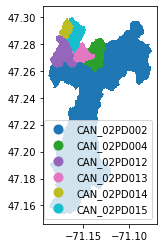

In [689]:
old_basin_gdf.reset_index().sort_values(by='unitarea', ascending=False).plot(column='basin_id', legend=True, legend_kwds={'loc': 'lower right'})

<AxesSubplot:>

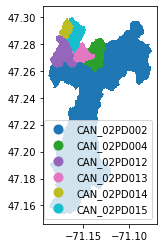

In [690]:
new_basin_gdf.plot(column='basin_id', legend=True, legend_kwds={'loc': 'lower right'})

In [691]:
# mimic function inputs
comid = comid
new_basins = new_basin_gdf.copy()
old_rivers_gdf = duplicate_comids_with_gauge_and_river.copy()

In [766]:
new_river_parts,new_river_gdf = split_river_segment(comid, old_basin_gdf, new_basins, old_rivers_gdf)

 -- find_closest_downstream_polygon(): identifying downstream poly for CAN_02PD013
 -- find_closest_downstream_polygon(): identifying downstream poly for CAN_02PD015
 -- find_closest_downstream_polygon(): identifying downstream poly for CAN_02PD012
 -- find_closest_downstream_polygon(): identifying downstream poly for CAN_02PD014


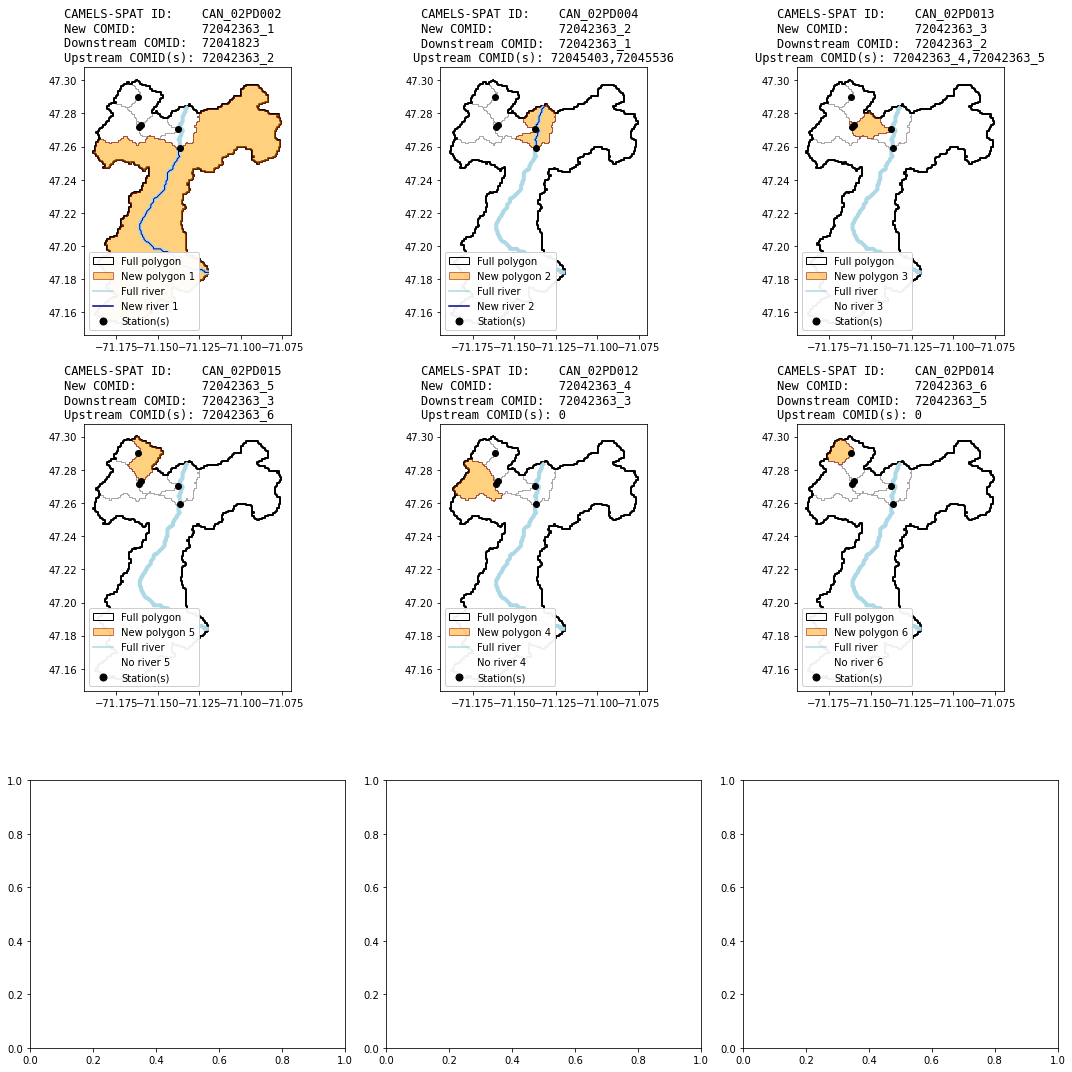

In [735]:
img_name = f"basin_and_river_split_COMID_{comid}.png"
plot_basin_and_river_split_outcomes(stations_gdf, comid, 
                                    old_basin_gdf, new_basin_gdf, 
                                    old_rivers_gdf, new_river_gdf,
                                    "")#img_folder/img_name)

In [733]:
img_folder,img_name

(PosixPath('/gpfs/tp/gwf/gwf_cmt/wknoben/camels_spat/camels-spat-data/TEMP_images_nested_basin_and_river_splits'),
 'basin_and_river_split_COMID_72042363.png')

#### river split dev

In [741]:
comid

72042363

In [742]:
# mimic function inputs
comid = comid
new_basins = new_basins.copy()
rivers_gdf = old_rivers_gdf.copy()

In [743]:
# 1. Select the correct subset
print(f" - 1. Working on basins {new_basins['basin_id'].values}") 
segment_mask = rivers_gdf.index.get_level_values(0) == comid
segment_gdf = rivers_gdf[segment_mask]
if not len(segment_gdf) > 0:
    print(f"!!! WARNING: No river segments found for COMID {comid}. Returning error codes.")

 - 1. Working on basins ['CAN_02PD002' 'CAN_02PD004' 'CAN_02PD013' 'CAN_02PD015' 'CAN_02PD012'
 'CAN_02PD014']


In [461]:
# 2. Perform a bunch of checks to ensure we've got this right
segment_comid = segment_gdf.index.get_level_values(0).unique()[0]
basins_comid = int(new_basins['new_COMID'][0].split('_')[0]) # just the first 
assert segment_comid == basins_comid, "COMID mismatch between selected river subset and new basin geodataframe"

# Switch the checks branch depending on the case we have
# 2a. Every gauge has an associated river segment
if len(segment_gdf) == len(new_basins):
    print(' - 2a. Equal number of basin polygons and river segments')
    
    # Ensure we have the same IDs in both basin and river geodataframes
    segment_stations = segment_gdf.index.get_level_values(1).values
    basins_stations = new_basins['basin_id'].values
    assert sorted(segment_stations) == sorted(basins_stations), "different station IDs detected in newly-split basins gdf and associated river segment gdf"

# 2b. Not every gauge has a river segment, could be:
# - a basin on the side of the main stem (e.g. CAN_05EE009, CAN_05EE006)
# - a headwater basin with no associated MERIT river stream segment (e.g. CAN_05DA007, CAN_05DA009, CAN_05DA010)
# - (and maybe other things?)
else:
    print(' - 2b. Number of basin polygons and river segments not equal')

    # Ensure we're indeed dealing with a case of basin-but-no-river, and not the reverse
    assert len(new_basins) > len(segment_gdf), "dealing with an unexpected case of more river segments than basin polygons"
    
    # Ensure that the IDs we do have (more basin IDs than river IDs) match
    segment_stations = segment_gdf.index.get_level_values(1).values
    basins_stations = new_basins['basin_id'].values
    assert set(segment_stations).issubset(set(basins_stations)), "different station IDs detected in newly-split basins gdf and associated river segment gdf"

    # Identify for which basin(s) we don't have a river segment
    basins_without_river_segment = []
    for basin_id in new_basins['basin_id']:
        if basin_id not in segment_gdf.index.get_level_values(1):
            print(f' - 2b. No river segment for basin {basin_id}')
            basins_without_river_segment.append(basin_id)

# 2c. Ensure the river actually falls inside the basin polygons
geometries_intersect = [g1.intersects(g2) for g1 in segment_gdf.geometry for g2 in new_basins.geometry]
assert any(geometries_intersect), "no intersecting geometries in newly-split gdf and associated river segment gdf"

 - 2a. Equal number of basin polygons and river segments


In [462]:
# 3. Find the longest river segment
ea_gdf = segment_gdf.to_crs(area_crs)
ea_gdf['length'] = ea_gdf['geometry'].length / 1000
longest_idx = ea_gdf['length'].idxmax()
longest_segment = segment_gdf.loc[longest_idx]['geometry'] # This is the one we need to split

#### special splitting functions

In [681]:
segment_gdf.loc[72042363,'CAN_02PD004']['up1']

72045403

In [675]:
new_river_gdf

,new_COMID,basin_id,NextDownID,up1,up2,up3,up4,new_len_km,geometry
0,72042363_1,CAN_02PD002,72041823,72042363_2,0,0,0,11.387251,"MULTILINESTRING ((-71.11917 47.18417, -71.1200..."
1,72042363_2,CAN_02PD004,72042363_1,72042363_3,0,0,0,3.239808,"MULTILINESTRING ((-71.13708 47.25792, -71.1370..."
2,72042363_3,CAN_02PD013,72042363_4,0,0,0,0,NaN,None
3,72042363_5,CAN_02PD015,72042363_6,0,0,0,0,NaN,None
4,72042363_4,CAN_02PD012,72042363_6,0,0,0,0,NaN,None
5,72042363_6,CAN_02PD014,72042363_4,0,0,0,0,NaN,None


In [682]:
def update_new_segments_comid_72042363(comid, new_segment_gdf, old_segment_gdf):

    # Complex case with nested and divergent polygons.
    # Here we set the downstream/upstream values correctly.

    assert comid == 72042363, f"update_new_segments_comid_72042363(): wrong COMID {comid} found."
    assert new_segment_gdf['basin_id'].values.tolist() == ['CAN_02PD002', 'CAN_02PD004', 'CAN_02PD013', 'CAN_02PD015', 'CAN_02PD012', 'CAN_02PD014'], \
        f"update_new_segments_comid_72042363(): basins not in expected order."

    # 0. CAN_02PD002: Most downstream basin, comes out correct
    
    # 1. CAN_02PD004: basin where everything belows flows into, also on the main MERIT river stem with 2 upstream segments
    new_segment_gdf.at[1,'up1'] = old_segment_gdf.loc[72042363,'CAN_02PD004']['up1']
    new_segment_gdf.at[1,'up2'] = old_segment_gdf.loc[72042363,'CAN_02PD004']['up2']
    
    # 2. CAN_02PD013: upstream of 02PD004 but not on MERIT river stem, contains everything else
    new_segment_gdf.at[2,'NextDownID'] = '72042363_2'
    new_segment_gdf.at[2,'up1'] = '72042363_4'
    new_segment_gdf.at[2,'up2'] = '72042363_5'
    
    # 3. CAN_02PD015: upstream of 02PD013, contains 02PD014
    new_segment_gdf.at[3,'NextDownID'] = '72042363_3'
    new_segment_gdf.at[3,'up1'] = '72042363_6'
    
    # 4. CAN_02PD012: upstream of 02PD013, contains nothing else
    new_segment_gdf.at[4,'NextDownID'] = '72042363_3'
    
    # 5. CAN_02PD014: upstream of 02PD015, contains nothing else
    new_segment_gdf.at[5,'NextDownID'] = '72042363_5'
       
    return new_segment_gdf

In [684]:
update_new_segments_comid_72042363(comid, new_river_gdf, segment_gdf)

,new_COMID,basin_id,NextDownID,up1,up2,up3,up4,new_len_km,geometry
0,72042363_1,CAN_02PD002,72041823,72042363_2,0,0,0,11.387251,"MULTILINESTRING ((-71.11917 47.18417, -71.1200..."
1,72042363_2,CAN_02PD004,72042363_1,72045403,72045536,0,0,3.239808,"MULTILINESTRING ((-71.13708 47.25792, -71.1370..."
2,72042363_3,CAN_02PD013,72042363_2,72042363_4,72042363_5,0,0,NaN,None
3,72042363_5,CAN_02PD015,72042363_3,72042363_6,0,0,0,NaN,None
4,72042363_4,CAN_02PD012,72042363_3,0,0,0,0,NaN,None
5,72042363_6,CAN_02PD014,72042363_5,0,0,0,0,NaN,None


#### end special splitting functions

In [347]:
# 4. Split accordingly
basin_ids  = [] 
new_comids = []
new_parts  = [] # Geometries
new_down= [] # NextDownID
new_up1 = [] # Upstream IDs
new_up2 = []
new_up3 = []
new_up4 = []

for basin_ix,basin_row in new_basins.iterrows():

    # identifiers
    basin_ids.append(basin_row.basin_id)
    new_comids.append(basin_row.new_COMID)

    # Check if we're using the general splitting code or dealing with a special case
    # Special case 1: small basin with no associated river segment 
    if basin_row.basin_id not in segment_gdf.index.get_level_values(1): # index level 1 is 'basin_id'
        
        # known in this case
        new_parts.append(None) # this results in an empty geometry
        new_up1.append(0) # Not on the MERIT river network so by definition no upstream polygons
        new_up2.append(0)
        new_up3.append(0)
        new_up4.append(0)

        # find the new_COMID of the larger basin this smaller one is inside of
        likely_downstream = find_closest_downstream_polygon(old_basin_gdf, new_basins, 
                                                            basin_row.basin_id)
        new_down.append(likely_downstream)
        
    # General case
    else:
        # get the matching row in the segment gdf
        segment_row = segment_gdf.xs(basin_row.basin_id, level='basin_id')
    
        # Compare this 'new_COMID' against the next one.
        # If it's the same, we're dealing with a case of multiple downstream gauges sharing this polygon.
        # In such cases we can't do anything yet, and we need to fill these fields later.
        if (basin_ix < len(new_basins)-1) and new_basins['new_COMID'].iloc[basin_ix+1] == basin_row.new_COMID:
            new_down.append('no-split') # downstream segment ID
            new_up1.append('no-split') # upstream IDs
            new_up2.append('no-split')
            new_up3.append('no-split')
            new_up4.append('no-split')
            new_parts.append('no-split') # geometry
    
        # If the 'new_COMID's do not match, we need to move to the splitting code.
        # This can be the first polygon, or any later ones so all the splitting code needs to be here.
        else:
    
            # downstream segment ID
            if (basin_ix == 0) or (new_down[basin_ix-1] == 'no-split'): # (first basin) or (collecting of downstream gauges we didn't need to split for)       
                new_down.append(str(segment_row.NextDownID.values[0])) # we're doing these from most downstream to upstream basin, so for the first one we keep the current NextDownID
            else:
                new_down.append(new_comids[basin_ix-1]) # for all others (unless we're in a special case - these need to be handled separately), keep the new_comid of previous basin
        
            # upstream IDs
            if basin_ix < len(new_basins)-1: # i.e., not the last basin we're looking at (len()-1 because we start indexing at 0; i.e. for length = 2, the last index we'll get is 1)
                new_up1.append(new_basins.iloc[basin_ix+1]['new_COMID']) # this works because we only do this until the second-to-last row
                new_up2.append(0)
                new_up3.append(0)
                new_up4.append(0)
            else: # i.e., most upstream segment, and thus the end point of the original stream segment
                new_up1.append(segment_row['up1'].values[0])
                new_up2.append(segment_row['up2'].values[0])
                new_up3.append(segment_row['up3'].values[0])
                new_up4.append(segment_row['up4'].values[0])
        
            # actual geometry
            # This if-statement should find the first basin where we need to split, and we need to do it this way
            # because the river line extends a little downstream of the most downstream polygon. Without this construction
            # we cut off this most downstream part that falls outside the actual basin polygon, but should be part of this 
            # river segment.
            if (basin_ix == 0) or all(part == 'no-split' for part in new_parts):
                combined_upstream = unary_union(new_basins[basin_ix+1:]['geometry']) # works even if this selects only one polygon
                new_parts.append(longest_segment.difference(combined_upstream))
            # For non-downstream basin polygons things are simpler
            else:
                new_parts.append(longest_segment.intersection(basin_row.geometry))

 -- find_closest_downstream_polygon(): identifying downstream poly for CAN_05DA010


In [441]:
# Check what came out of the splitting code
for d,l in zip(['basin_id','new_comids','new_parts','new_down','new_up1','new_up4','new_up4','new_up4'],
                [basin_ids,new_comids,new_parts,new_down,new_up1,new_up2,new_up3,new_up4]):
    print(f'{d:<10}:{l}')

basin_id  :['USA_10258500', 'USA_10259000']
new_comids:['77029498_1', '77029498_2']
new_parts :[<MULTILINESTRING ((-116.536 33.745, -116.536 33.745, -116.536 33.745), (-116...>, None]
new_down  :[77028618, 0]
new_up1   :[77030310, 0]
new_up4   :[77030339, 0]
new_up4   :[0, 0]
new_up4   :[0, 0]


#### mini-dev



In [326]:
DEV_old_basins = old_basin_gdf
DEV_new_basins = new_basins
DEV_basin_id = basin_row.basin_id

In [327]:
# Get the polygon of the basin we want to identify the downstream basin for
basin_info = DEV_new_basins[DEV_new_basins['basin_id'] == basin_id]
upstream = basin_info['geometry'].iloc[0] # needs .iloc because otherwise we select a masked gdf, not a polygon

In [329]:
# Check with which original (large) other basin polygons this one is inside of
old_ids = []
old_areas = []
old_within = [] # shapely.within(): poly A is within B, and no A on exterior edge of B
old_overlaps = [] # shapely.overlaps(): poly A and B have some (but not all) common points
# we don't want to use intersect if possible, because this could gives us touching polygons 
# (i.e. polygons sharing ONLY a border) and this is not what we want here
#old_intersects = [] # True if any of overlap(), touches(), covers(), within() is True
for (old_comid,old_id), old_row in DEV_old_basins.iterrows():
    if old_id != DEV_basin_id:
        old_ids.append(old_id)
        old_areas.append(old_row.unitarea)
        old_within.append(upstream.within(old_row['geometry']))
        old_overlaps.append(upstream.intersects(old_row['geometry']))
test_df = pd.DataFrame({'station': old_ids, 'area':old_areas, 
                        'shapely.within': old_within, 'shapely.overlaps': old_overlaps})
test_df['downstream of target'] = test_df['shapely.within'] | test_df['shapely.overlaps']

In [331]:
# Find the smallest downstream gauge/polygon the target one is still inside of: 
# this should be the first downstream one from the target
filtered_df = test_df[test_df["downstream of target"] == True]
smallest_area_row = filtered_df.loc[filtered_df["area"].idxmin()]
downstream_gauge = smallest_area_row["station"]

In [332]:
DEV_new_basins[DEV_new_basins['basin_id'] == downstream_gauge]['new_COMID'].iloc[0]

'71032880_1'

In [333]:
def find_closest_downstream_polygon(old_basins, new_basins, basin_id):

    '''Takes basin_id in new_basins, and identifies the most likely 
        immediately downstream basin using old_basins'''

    print(f' -- find_closest_downstream_polygon(): identifying downstream poly for {basin_id}')

    # Get the polygon of the basin we want to identify the downstream basin for
    basin_info = new_basins[new_basins['basin_id'] == basin_id]
    upstream = basin_info['geometry'].iloc[0] # needs .iloc because otherwise we select a masked gdf, not a polygon

    # Check with which original (large) other basin polygons this one is inside of
    old_ids = []
    old_areas = []
    old_within = [] # shapely.within(): poly A is within B, and no A on exterior edge of B
    old_overlaps = [] # shapely.overlaps(): poly A and B have some (but not all) common points
    # we don't want to use intersect if possible, because this could gives us touching polygons 
    # (i.e. polygons sharing ONLY a border) and this is not what we want here
    #old_intersects = [] # True if any of overlap(), touches(), covers(), within() is True
    for (old_comid,old_id), old_row in DEV_old_basins.iterrows():
        if old_id != DEV_basin_id:
            old_ids.append(old_id)
            old_areas.append(old_row.unitarea)
            old_within.append(upstream.within(old_row['geometry']))
            old_overlaps.append(upstream.intersects(old_row['geometry']))
    test_df = pd.DataFrame({'station': old_ids, 'area':old_areas, 
                            'shapely.within': old_within, 'shapely.overlaps': old_overlaps})
    test_df['downstream of target'] = test_df['shapely.within'] | test_df['shapely.overlaps']

    # Find the smallest downstream gauge/polygon the target one is still inside of: 
    # this should be the first downstream one from the target
    filtered_df = test_df[test_df["downstream of target"] == True]
    smallest_area_row = filtered_df.loc[filtered_df["area"].idxmin()]
    downstream_gauge = smallest_area_row["station"]
    
    # Now map that back onto the new_COMIDs we defined in the previous step
    return new_basins[new_basins['basin_id'] == downstream_gauge]['new_COMID'].iloc[0]

#### end

In [442]:
# 5. Fill the 'no-splits'
num_entries = len(new_parts)
for i in range(num_entries): # check every list entry
    if new_parts[i] == 'no-split': # find the first valid polygon and replace
        for j in range(i+1, num_entries):
                if new_parts[j] != 'no-split': # if not no-split, must be (multi)poly
                    new_down[i] = new_down[j] # downstream segment ID
                    new_up1[i] = new_up1[j] # upstream IDs
                    new_up2[i] = new_up2[j]
                    new_up3[i] = new_up3[j]
                    new_up4[i] = new_up4[j]
                    new_parts[i] = new_parts[j] # geometry
                    break # critical, because otherwise it'll keep going until the last one

In [443]:
# 6. put the whole thing back together
new_segments = gpd.GeoDataFrame(data={'new_COMID': new_comids,
                                      'basin_id': basin_ids,
                                      'NextDownID':new_down,
                                      'up1':new_up1,
                                      'up2':new_up2,
                                      'up3':new_up3,
                                      'up4':new_up4},
                                geometry=new_parts,
                                crs='EPSG:4326')
new_segments['new_len_km'] = new_segments.to_crs(area_crs).length / 1000 # [m] > [km]
new_segments = new_segments[['new_COMID','basin_id','NextDownID','up1','up2','up3','up4','new_len_km','geometry']] # easier to debug when column order matches 'gdf'

In [444]:
# 7. Ensure we did not lose/create extra river
old_length = segment_gdf['new_len_km'].max()
new_length = new_segments.groupby('new_COMID').first()['new_len_km'].sum()
assert np.isclose(old_length, new_length), "river length mismatch before and after segment split"

In [445]:
tmp_dir = Path('./transfer_temp')
tmp_dir.mkdir(exist_ok=True, parents=True)
segment_gdf.to_file(tmp_dir/f'old_{comid}.shp')
new_segments.to_file(tmp_dir/f'split_{comid}.shp')

/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


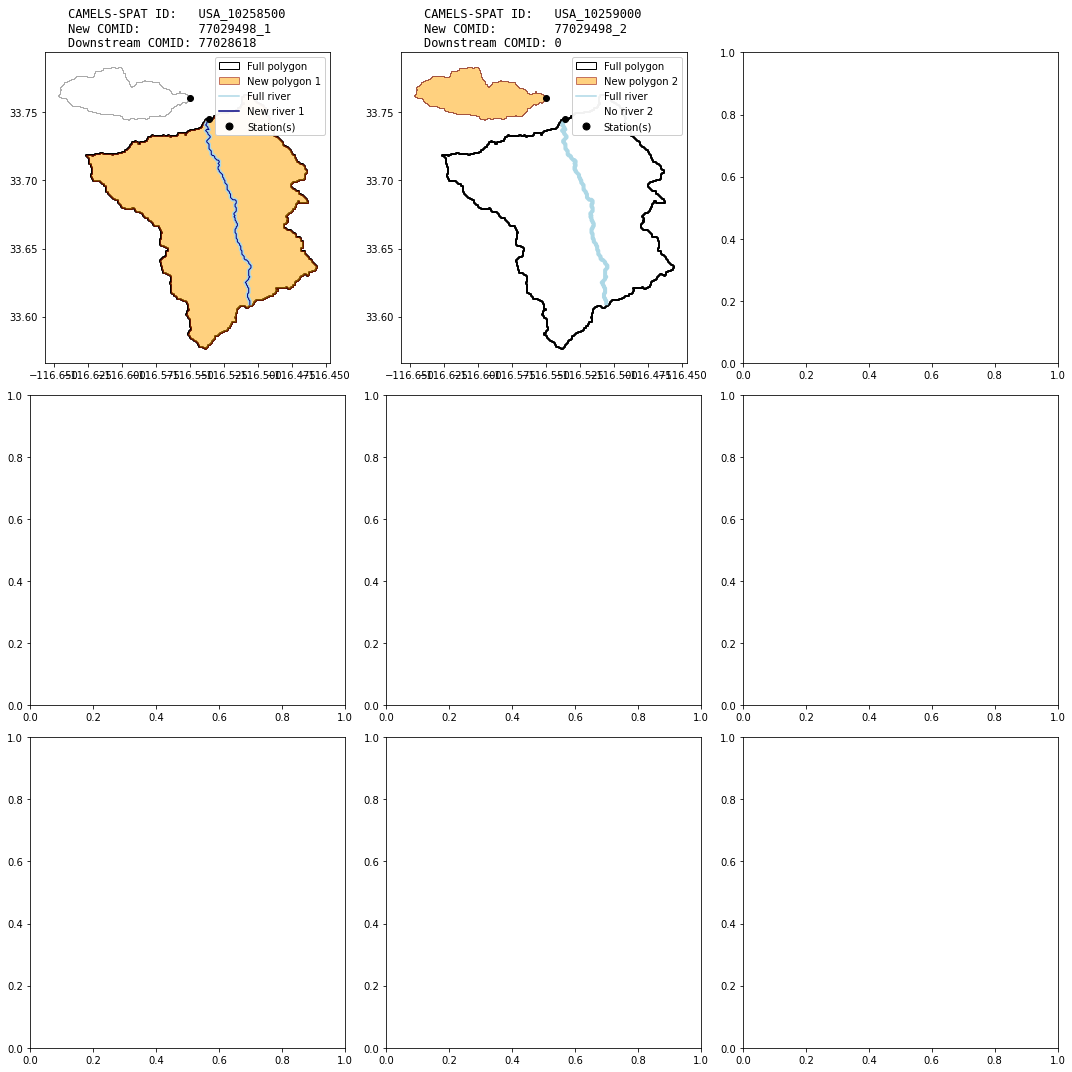

In [446]:
plot_basin_and_river_split_outcomes(stations_gdf, comid, 
                                    old_basin_gdf, new_basin_gdf, 
                                    old_river_gdf, new_segments)

# INSERT HERE

In [685]:
def update_new_segments_comid_72042363(comid, new_segment_gdf, old_segment_gdf):

    # Complex case with nested and divergent polygons.
    # Here we set the downstream/upstream values correctly.

    assert comid == 72042363, f"update_new_segments_comid_72042363(): wrong COMID {comid} found."
    assert new_segment_gdf['basin_id'].values.tolist() == ['CAN_02PD002', 'CAN_02PD004', 'CAN_02PD013', 'CAN_02PD015', 'CAN_02PD012', 'CAN_02PD014'], \
        f"update_new_segments_comid_72042363(): basins not in expected order."

    # 0. CAN_02PD002: Most downstream basin, comes out correct
    
    # 1. CAN_02PD004: basin where everything belows flows into, also on the main MERIT river stem with 2 upstream segments
    new_segment_gdf.at[1,'up1'] = old_segment_gdf.loc[72042363,'CAN_02PD004']['up1']
    new_segment_gdf.at[1,'up2'] = old_segment_gdf.loc[72042363,'CAN_02PD004']['up2']
    
    # 2. CAN_02PD013: upstream of 02PD004 but not on MERIT river stem, contains everything else
    new_segment_gdf.at[2,'NextDownID'] = '72042363_2'
    new_segment_gdf.at[2,'up1'] = '72042363_4'
    new_segment_gdf.at[2,'up2'] = '72042363_5'
    
    # 3. CAN_02PD015: upstream of 02PD013, contains 02PD014
    new_segment_gdf.at[3,'NextDownID'] = '72042363_3'
    new_segment_gdf.at[3,'up1'] = '72042363_6'
    
    # 4. CAN_02PD012: upstream of 02PD013, contains nothing else
    new_segment_gdf.at[4,'NextDownID'] = '72042363_3'
    
    # 5. CAN_02PD014: upstream of 02PD015, contains nothing else
    new_segment_gdf.at[5,'NextDownID'] = '72042363_5'
       
    return new_segment_gdf

In [482]:
def update_new_segments_comid_72040863(comid, segment_gdf):

    # This is the case where there are WSC and USGS gauges side-by-side,
    # and we thus have two identical (large) upstream parts of the polygon.
    # This interferes with the finding of the correct NextDownID value.
    # Because there is only a single case like this, it is easier to simply
    # catch this and deal with separately instead of trying to generalize.

    assert comid == 72040863, f"update_new_segments_comid_72040863(): wrong COMID {comid} found."
    assert segment_gdf['basin_id'].values.tolist() == ['CAN_01AD002', 'CAN_01AE001', 'USA_01013500'], f"update_new_segments_comid_72040863(): basins not in expected order."

    segment_gdf.at[1,'NextDownID'] = '72040863_1'
    segment_gdf.at[2,'NextDownID'] = '72040863_1'
   
    return segment_gdf

In [483]:
def split_river_comid_77029498(comid, basin_gdf, river_gdf):

    # This is a case where two gauges are located in the same polygon, 
    # but both are different headwaters flowing into the main stem. No 
    # need to split any polygons, but we do need to assign unique COMIDs
    # to both polygons

    assert comid == 77029498, f"split_river_comid_77029498(): wrong COMID {comid} found."
    assert basin_gdf.iloc[0]['basin_id'] == 'USA_10258500', f"split_river_comid_77029498(): basins not in expected order."
    
    basin_ids  = basin_gdf['basin_id'].values.tolist() # Should be: USA_10258500, USA_10259000 (see assert() above)
    new_comids = basin_gdf['new_COMID'].values.tolist()
    new_parts  = [river_gdf.loc[comid,'USA_10258500']['geometry']  , None] 
    new_down   = [river_gdf.loc[comid,'USA_10258500']['NextDownID'], 0]
    new_up1    = [river_gdf.loc[comid,'USA_10258500']['up1']       , 0]
    new_up2    = [river_gdf.loc[comid,'USA_10258500']['up2']       , 0]
    new_up3    = [river_gdf.loc[comid,'USA_10258500']['up3']       , 0]
    new_up4    = [river_gdf.loc[comid,'USA_10258500']['up4']       , 0]
    
    return basin_ids, new_comids, new_parts, new_down, new_up1, new_up2, new_up3, new_up4

In [355]:
def find_closest_downstream_polygon(old_basins, new_basins, basin_id):

    '''Takes basin_id in new_basins, and identifies the most likely 
        immediately downstream basin using old_basins'''

    print(f' -- find_closest_downstream_polygon(): identifying downstream poly for {basin_id}')

    # Get the polygon of the basin we want to identify the downstream basin for
    basin_info = new_basins[new_basins['basin_id'] == basin_id]
    upstream = basin_info['geometry'].iloc[0] # needs .iloc because otherwise we select a masked gdf, not a polygon

    # Check with which original (large) other basin polygons this one is inside of
    old_ids = []
    old_areas = []
    old_within = [] # shapely.within(): poly A is within B, and no A on exterior edge of B
    old_overlaps = [] # shapely.overlaps(): poly A and B have some (but not all) common points
    # we don't want to use intersect if possible, because this could gives us touching polygons 
    # (i.e. polygons sharing ONLY a border) and this is not what we want here
    #old_intersects = [] # True if any of overlap(), touches(), covers(), within() is True
    for (old_comid,old_id), old_row in old_basins.iterrows():
        if old_id != basin_id:
            old_ids.append(old_id)
            old_areas.append(old_row.unitarea)
            old_within.append(upstream.within(old_row['geometry']))
            old_overlaps.append(upstream.intersects(old_row['geometry']))
    test_df = pd.DataFrame({'station': old_ids, 'area':old_areas, 
                            'shapely.within': old_within, 'shapely.overlaps': old_overlaps})
    test_df['downstream of target'] = test_df['shapely.within'] | test_df['shapely.overlaps']

    # Find the smallest downstream gauge/polygon the target one is still inside of: 
    # this should be the first downstream one from the target
    filtered_df = test_df[test_df["downstream of target"] == True]
    smallest_area_row = filtered_df.loc[filtered_df["area"].idxmin()]
    downstream_gauge = smallest_area_row["station"]
    
    # Now map that back onto the new_COMIDs we defined in the previous step
    return new_basins[new_basins['basin_id'] == downstream_gauge]['new_COMID'].iloc[0]

In [765]:
def split_river_segment(comid, old_basins, new_basins, rivers_gdf):

    # 1. Select the correct subset
    segment_mask = rivers_gdf.index.get_level_values(0) == comid
    segment_gdf = rivers_gdf[segment_mask]
    if not len(segment_gdf) > 0:
        print(f"!!! WARNING: No river segments found for COMID {comid}. Returning error codes.")
        return -1,-1

    # 2. Perform a bunch of checks to ensure we've got this right
    segment_comid = segment_gdf.index.get_level_values(0).unique()[0]
    basins_comid = int(new_basins['new_COMID'][0].split('_')[0]) # just the first 
    assert segment_comid == basins_comid, "COMID mismatch between selected river subset and new basin geodataframe"
    
    # Switch the checks branch depending on the case we have
    # 2a. Every gauge has an associated river segment
    if len(segment_gdf) == len(new_basins):
        
        # Ensure we have the same IDs in both basin and river geodataframes
        segment_stations = segment_gdf.index.get_level_values(1).values
        basins_stations = new_basins['basin_id'].values
        assert sorted(segment_stations) == sorted(basins_stations), "different station IDs detected in newly-split basins gdf and associated river segment gdf"
    
    # 2b. Not every gauge has a river segment, could be:
    # - a basin on the side of the main stem (e.g. CAN_05EE009, CAN_05EE006)
    # - a headwater basin with no associated MERIT river stream segment (e.g. CAN_05DA007, CAN_05DA009, CAN_05DA010)
    # - (and maybe other things?)
    else:
    
        # Ensure we're indeed dealing with a case of basin-but-no-river, and not the reverse
        assert len(new_basins) > len(segment_gdf), "dealing with an unexpected case of more river segments than basin polygons"
        
        # Ensure that the IDs we do have (more basin IDs than river IDs) match
        segment_stations = segment_gdf.index.get_level_values(1).values
        basins_stations = new_basins['basin_id'].values
        assert set(segment_stations).issubset(set(basins_stations)), "different station IDs detected in newly-split basins gdf and associated river segment gdf"
    
    # Ensure the river actually falls inside the basin polygons
    geometries_intersect = [g1.intersects(g2) for g1 in segment_gdf.geometry for g2 in new_basins.geometry]
    assert any(geometries_intersect), "no intersecting geometries in newly-split gdf and associated river segment gdf"

    # 3. Find the longest river segment
    ea_gdf = segment_gdf.to_crs(area_crs)
    ea_gdf['length'] = ea_gdf['geometry'].length / 1000
    longest_idx = ea_gdf['length'].idxmax()
    longest_segment = segment_gdf.loc[longest_idx]['geometry'] # This is the one we need to split

    # 4. Split accordingly
    # 4a. Escape special cases that cannot be handled by the more general code below
    # Cases here have divergent nested basins; code below assumes only linearly nested basins
    if comid == 77029498:
        basin_ids, new_comids, new_parts, new_down, new_up1, new_up2, new_up3, new_up4 = \
            split_river_comid_77029498(comid, new_basins, segment_gdf)
    
    # 4b. General case:
    else:
        basin_ids  = [] 
        new_comids = []
        new_parts  = [] # Geometries
        new_down= [] # NextDownID
        new_up1 = [] # Upstream IDs
        new_up2 = []
        new_up3 = []
        new_up4 = []
        
        for basin_ix,basin_row in new_basins.iterrows():
        
            # identifiers
            basin_ids.append(basin_row.basin_id)
            new_comids.append(basin_row.new_COMID)
        
            # Check if we're using the general splitting code or dealing with a special case
            # Special case 1: small basin with no associated river segment 
            if basin_row.basin_id not in segment_gdf.index.get_level_values(1): # index level 1 is 'basin_id'
                
                # known in this case
                new_parts.append(None) # this results in an empty geometry
                new_up1.append(0) # Not on the MERIT river network so by definition no upstream polygons
                new_up2.append(0)
                new_up3.append(0)
                new_up4.append(0)
        
                # find the new_COMID of the larger basin this smaller one is inside of
                likely_downstream = find_closest_downstream_polygon(old_basins, new_basins, basin_row.basin_id)
                new_down.append(likely_downstream)
                
            # General case
            else:
                # get the matching row in the segment gdf
                segment_row = segment_gdf.xs(basin_row.basin_id, level='basin_id')
            
                # Compare this 'new_COMID' against the next one.
                # If it's the same, we're dealing with a case of multiple downstream gauges sharing this polygon.
                # In such cases we can't do anything yet, and we need to fill these fields later.
                if (basin_ix < len(new_basins)-1) and new_basins['new_COMID'].iloc[basin_ix+1] == basin_row.new_COMID:
                    new_down.append('no-split') # downstream segment ID
                    new_up1.append('no-split') # upstream IDs
                    new_up2.append('no-split')
                    new_up3.append('no-split')
                    new_up4.append('no-split')
                    new_parts.append('no-split') # geometry
            
                # If the 'new_COMID's do not match, we need to move to the splitting code.
                # This can be the first polygon, or any later ones so all the splitting code needs to be here.
                else:
            
                    # downstream segment ID
                    if (basin_ix == 0) or (new_down[basin_ix-1] == 'no-split'): # (first basin) or (collecting of downstream gauges we didn't need to split for)       
                        new_down.append(str(segment_row.NextDownID.values[0])) # we're doing these from most downstream to upstream basin, so for the first one we keep the current NextDownID
                    else:
                        new_down.append(new_comids[basin_ix-1]) # for all others (unless we're in a special case - these need to be handled separately), keep the new_comid of previous basin
                
                    # upstream IDs
                    if basin_ix < len(new_basins)-1: # i.e., not the last basin we're looking at (len()-1 because we start indexing at 0; i.e. for length = 2, the last index we'll get is 1)
                        new_up1.append(new_basins.iloc[basin_ix+1]['new_COMID']) # this works because we only do this until the second-to-last row
                        new_up2.append(0)
                        new_up3.append(0)
                        new_up4.append(0)
                    else: # i.e., most upstream segment, and thus the end point of the original stream segment
                        new_up1.append(segment_row['up1'].values[0])
                        new_up2.append(segment_row['up2'].values[0])
                        new_up3.append(segment_row['up3'].values[0])
                        new_up4.append(segment_row['up4'].values[0])
                
                    # actual geometry
                    # This if-statement should find the first basin where we need to split, and we need to do it this way
                    # because the river line extends a little downstream of the most downstream polygon. Without this construction
                    # we cut off this most downstream part that falls outside the actual basin polygon, but should be part of this 
                    # river segment.
                    if (basin_ix == 0) or all(part == 'no-split' for part in new_parts):
                        combined_upstream = unary_union(new_basins[basin_ix+1:]['geometry']) # works even if this selects only one polygon
                        new_parts.append(longest_segment.difference(combined_upstream))
                    # For non-downstream basin polygons things are simpler
                    else:
                        new_parts.append(longest_segment.intersection(basin_row.geometry))

    # 5. Fill the 'no-splits'
    num_entries = len(new_parts)
    for i in range(num_entries): # check every list entry
        if new_parts[i] == 'no-split': # find the first valid polygon and replace
            for j in range(i+1, num_entries):
                    if new_parts[j] != 'no-split': # if not no-split, must be (multi)poly
                        new_down[i] = new_down[j] # downstream segment ID
                        new_up1[i] = new_up1[j] # upstream IDs
                        new_up2[i] = new_up2[j]
                        new_up3[i] = new_up3[j]
                        new_up4[i] = new_up4[j]
                        new_parts[i] = new_parts[j] # geometry
                        break # critical, because otherwise it'll keep going until the last one
    
    # 6. put the whole thing back together
    # 6a. General case
    new_segments = gpd.GeoDataFrame(data={'new_COMID': new_comids,
                                          'basin_id': basin_ids,
                                          'NextDownID':new_down,
                                          'up1':new_up1,
                                          'up2':new_up2,
                                          'up3':new_up3,
                                          'up4':new_up4},
                                    geometry=new_parts,
                                    crs='EPSG:4326')
    new_segments['new_len_km'] = new_segments.to_crs(area_crs).length / 1000 # [m] > [km]
    new_segments = new_segments[['new_COMID','basin_id','NextDownID','up1','up2','up3','up4','new_len_km','geometry']] # easier to debug when column order matches 'gdf'

    # 6b. Handle minor updates to special cases
    if comid == 72040863:
        new_segments = update_new_segments_comid_72040863(comid, new_segments)
    elif comid == 72042363:
        new_segments = update_new_segments_comid_72042363(comid, new_segments, segment_gdf)
    
    # 7. Ensure we did not lose/create extra river
    old_length = segment_gdf['new_len_km'].max()
    new_length = new_segments.groupby('new_COMID').first()['new_len_km'].sum()
    assert np.isclose(old_length, new_length), "river length mismatch before and after segment split"

    # 8. Ensure we still have the original downstream and upstream IDs somewhere in the new dataframe
    for column in ['NextDownID','up1','up2','up3','up4']:
        for value in segment_gdf[column].values:
            assert (value in new_river_gdf[column].values) or (str(value) in new_river_gdf[column].values), f"{column} value {value} not found in {new_river_gdf[column].values}"
    
    return new_parts, new_segments

In [734]:
def plot_basin_and_river_split_outcomes(station_gdf, comid, 
                                        old_basin_gdf, new_basin_gdf, 
                                        old_river_gdf, new_river_gdf,
                                        save_path=''): # plots to screen if no path given

    # Mimic the basin order we used in the basin splitting code
    old_basin_gdf = old_basin_gdf.sort_values(by='unitarea', ascending=False) # sort by area; largest to smallest
    old_basin_gdf = old_basin_gdf.reset_index()

    # Mimic the segment selection we used in the river splitting code
    river_mask = old_river_gdf.index.get_level_values(0) == comid
    river_gdf = old_river_gdf[river_mask]
    if not len(river_gdf) > 0:
        plot_river = False
    else:
        plot_river = True
        ea_gdf = river_gdf.to_crs(area_crs)
        ea_gdf['length'] = ea_gdf['geometry'].length / 1000
        longest_idx = ea_gdf['length'].idxmax()
        longest_segment = river_gdf.loc[longest_idx]['geometry'] # This is the one we need to split
        
    # Select the station(s) we want to plot here
    station_mask = stations_gdf['station_in_duplicate_comid?'] == comid
    stations_plot = stations_gdf[station_mask].copy()
    
    # We'll make a standard 3x3 layout, because we know that at most we'll have 9 parts to deal with
    fig, axs = plt.subplots(3,3,figsize=(15,15))
    axs = axs.flatten() # simplifies loops

    # Loop over the parts and plot them
    for ix in range(len(old_basin_gdf)):
        ax = axs[ix]
        new_comid = new_basin_gdf.iloc[ix]['new_COMID']

        # set up the legend items first so we can either plot the new river or not, for cases where basin has no river poly
        old_basin_patch = Patch(facecolor='None', edgecolor='black', label='Full polygon')
        new_basin_patch = Patch(facecolor='orange', edgecolor='darkred', alpha=.5, label=f"New polygon {new_comid[-1]}")
        old_river = mlines.Line2D([], [], color='lightblue', label='Full river')
        new_river = mlines.Line2D([], [], color='navy', label=f'New river {new_comid[-1]}')
        no_river = mlines.Line2D([], [], color='None', label=f'No river {new_comid[-1]}')
        station = mlines.Line2D([], [], color='k', marker='o', linestyle='None', markersize=7, label='Station(s)')

        # basin polygons
        new_basin_gdf.plot(ax=ax, color='None', edgecolor='darkgrey', linewidth=1, zorder=0)
        gpd.GeoSeries(old_basin_gdf.iloc[0].geometry).plot(ax=ax, color='None', edgecolor='black', linewidth=2, zorder=1) # old big shape
        gpd.GeoSeries(new_basin_gdf.iloc[ix].geometry).plot(ax=ax, color='orange', edgecolor='darkred', alpha=.5, zorder=2) # new split shape

        # rivers
        if plot_river:
            new_segment = new_river_gdf[new_river_gdf['new_COMID'] == new_comid]['geometry']
            new_downstream = new_river_gdf[new_river_gdf['new_COMID'] == new_comid]['NextDownID'].values[0]
            new_upstream = [str(new_river_gdf[new_river_gdf['new_COMID'] == new_comid][up].values[0]) for up in ['up1','up2','up3','up4'] if str(new_river_gdf[new_river_gdf['new_COMID'] == new_comid][up].values[0]) != '0']
            gpd.GeoSeries(longest_segment).plot(ax=ax, color='lightblue', linewidth=4, zorder=3) # old big river
            # check if we have an actual segment (some catchments aren't on a MERIT river)
            if not any(new_segment.isna()):
                gpd.GeoSeries(new_segment).plot(ax=ax, color='navy', linewidth=1, zorder=4) # new split river
                legend_handles = [old_basin_patch, new_basin_patch, old_river, new_river, station]
            else:
                legend_handles = [old_basin_patch, new_basin_patch, old_river, no_river, station]
        else:
            legend_handles = [old_basin_patch, new_basin_patch, station]
            new_downstream = 'not part of CS'

        # gauge
        stations_plot.plot(ax=ax,color='k', zorder=5)
        
        # legend
        ax.legend(handles=legend_handles, loc='best', framealpha=0.95)

        # title
        title = (f"CAMELS-SPAT ID:    {old_basin_gdf.iloc[ix]['basin_id']:<15}\n"
                 f"New COMID:         {new_comid:<15}\n"
                 f"Downstream COMID:  {new_downstream:<15}\n"
                 f"Upstream COMID(s): {','.join(new_upstream) if any(new_upstream) else '0':<15}"
                )    
        ax.set_title(title, fontfamily='monospace') # monospace font to ensure easy-reading alignments
    
    plt.tight_layout()
    if save_path != '':
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()

In [697]:
new_comid = '77029498_1'

In [723]:
new_upstream = [str(new_segments[new_segments['new_COMID'] == new_comid][up].values[0]) for up in ['up1','up2','up3','up4'] if str(new_segments[new_segments['new_COMID'] == new_comid][up].values[0]) != '0']

In [724]:
','.join(ups) if any(ups) else '0'

'77030310,77030339'

In [714]:
new_segments[new_segments['new_COMID'] == new_comid][['up1','up2','up3','up4']]

,up1,up2,up3,up4
0,77030310,77030339,0,0


In [696]:
new_segments

,new_COMID,basin_id,NextDownID,up1,up2,up3,up4,new_len_km,geometry
0,77029498_1,USA_10258500,77028618,77030310,77030339,0,0,18.398444,"MULTILINESTRING ((-116.53583 33.74542, -116.53..."
1,77029498_2,USA_10259000,0,0,0,0,0,NaN,None


## END DEV

In [382]:
def split_nested_polygon(comid, comid_gdf, stations_gdf, img_folder, debug=False, overwrite=True):

    # 0. Restart after crash
    img_name = f"basin_split_COMID_{comid}.png"
    if not overwrite:
        if (img_folder/img_name).exists():
            print(f"File {img_name} found. Exiting early.")
            return -1,-1,-1
    
    # 1. Reset the index for easier access
    gdf = comid_gdf.sort_values(by='unitarea', ascending=False) # sort by area; largest to smallest
    gdf = gdf.reset_index()
    if debug: print(f"Dataframe:\n", gdf)

    # 2. Checks
    run_area_check = True # Area check assumes we always have a single largest polygon that the others fall into. This needs to be disabled for some rare cases
    poly_part_of_this_many_basins = len(gdf)
    assert poly_part_of_this_many_basins > 1, f"Only a single basin contains polygon {comid}" # assert polygon occurs in the shapefiles of at least two basins
    assert len(gdf['COMID'].unique()) == 1, f"Multiple different COMIDs in {df}" # assert we're only dealing with a single polygon
    assert gdf['COMID'].unique()[0] == comid, f"Mismatch between function input {comid} and dataframe contents {df}" # No silly mix-ups with inputs

    # 3. Identify in how many parts we need to split this
    # I.e., in cases where the full river basin contains more than 1 nested gauge,
    #  a polygon may appear in three or more CAMELS-SPAT basins, but the polygon
    #  itself may only contain one of the multiple nested gauges in the larger
    #  river basin. 

    # 3a. We can use the unique 'unitarea' values to figure out in how many parts
    # we need to split this, but we may need to be wary of rounding precision.
    tolerance = 5 # decimal places, because unitarea is in km^2 this effectively
                  # means we consider areas equivalent if they are within 10 m^2 of
                  # one another
    num_parts = gdf['unitarea'].round(tolerance).nunique()
    
    # 3b. We can also get this directly from the station locations:
    # Check how many of our station location fall inside the first polygon:
    #  because we sorted the geodataframe this should be the whole thing.
    # NOTE: this will return falls for stations that are exactly ON the polygon edge,
    #       only stations IN the polygon are counted
    station_in_poly_mask = gdf.iloc[0]['geometry'].contains(stations_gdf['geometry'])
    num_parts_from_station = station_in_poly_mask.sum()+1 # +1, because two stations divide the poly in three parts
    
    # 3c. Confirm both numbers are the same
    # # Handle the special case where we have a Canadian and US gauge on the same river, and we know we need 2 parts, not 3
    if comid == 72040863: 
        assert num_parts == 2, "Incorrect number of splits found for transboundary polygon 72040863" # We know this from manual inspection - at the MERIT DEM resolution 2 parts is correct
    
    # Handle a bunch of special cases where the more general code fails, because the station counts aren't helpful
    # We know the below is correct from manual inspection
    elif (comid == 75012494) or (comid == 78013257) or (comid == 78016700) or (comid == 78016804):
        assert num_parts == 2, f"Incorrect number of splits found for polygon {comid}"
    elif (comid == 78013328):
        assert num_parts == 3, f"Incorrect number of splits found for polygon {comid}"

    # General case
    else:
        assert num_parts == num_parts_from_station, "Different number of parts to split polygon into returned by different approaches"
    if debug: print(f"\nSplitting polygon into {num_parts} parts.")

    # 4. Split the polygon into parts
    # 4a. Escape special cases that cannot be handled by the more general code below. 
    # Cases here have divergent nested basins; code below assumes only linearly nested basins
    if comid == 72042363:
        new_parts, new_comids = split_comid_72042363(comid, gdf, stations_gdf)
    elif comid == 72044865:
        new_parts, new_comids = split_comid_72044865(comid, gdf, stations_gdf)
    elif comid == 72055698:
        new_parts, new_comids = split_comid_72055698(comid, gdf, stations_gdf)
    elif comid == 77009034:
        new_parts, new_comids = split_comid_77009034(comid, gdf, stations_gdf)
        run_area_check = False # we have two separate polygons here, not a smaller one nested inside a larger one like the area check in (9) assumes
    elif comid == 77010786:
        new_parts, new_comids = split_comid_77010786(comid, gdf, stations_gdf)
        run_area_check = False # we have two separate polygons here, not a smaller one nested inside a larger one like the area check in (9) assumes
    elif comid == 77029498:
        new_parts, new_comids = split_comid_77029498(comid, gdf, stations_gdf)
        run_area_check = False # we have two separate polygons here, not a smaller one nested inside a larger one like the area check in (9) assumes
    elif comid == 78013328:
        new_parts, new_comids = split_comid_78013328(comid, gdf, stations_gdf)
        run_area_check = False # we have two separate polygons here, not a smaller one nested inside a larger one like the area check in (9) assumes
    elif comid == 78020663:
        new_parts, new_comids = split_comid_78020663(comid, gdf, stations_gdf)
        run_area_check = False # we have two separate polygons here, not a smaller one nested inside a larger one like the area check in (9) assumes
        
    # 4b. Simpler cases can be handled as follows:
    else:  
        new_parts = []
        new_comids = []
        max_ix = len(gdf)-1 # length (e.g. 4) means indexing stops at 3
        part_id = 0 # we'll use this to number the new polygon parts
        for ix,row in gdf.iterrows():
            
            # Handle special case: most upstream, smallest (because we sorted this way), polygon
            if ix == max_ix: 
                new_parts.append(gdf['geometry'].iloc[ix]) # We can simply add this because it already exist as the final part
                part_id += 1 # we've created a new part so increment by 1
                new_comids.append(f"{comid}_{part_id}")
        
            # Rest
            else: 
                # Check if we're dealing with the case of: multiple nested gauges in the basin, but not the polygon
                if gdf['unitarea'].iloc[ix].round(tolerance) == gdf['unitarea'].iloc[ix+1].round(tolerance):
                    new_parts.append('no-split')
                    new_comids.append(f"{comid}_{part_id}")
                    
                # Or if we're at the point where we're dealing with nested gauge(s) in this specific polygon
                else:
                    new_parts.append(gdf['geometry'].iloc[ix].difference(gdf['geometry'].iloc[ix+1])) # new poly
                    part_id += 1 # we've created a new part so increment by 1   
                    new_comids.append(f"{comid}_{part_id}")

    # 5. Clean the newly generated geometries to remove any tendrils
    precision = 1e-08 # Define the precision level
    area_tol = 2e-5 # tolerance % for accepted changes
    
    # 5a. Loop over the new parts we just created
    updated_parts = []
    for new_part in new_parts: # Gives either 'no-split' or a geometry
        
        # Skip the ones we haven't filled yet (this will come later, after fixing the ones we do have)
        if new_part == 'no-split':
            updated_parts.append(new_part)
            continue # to next new_part
    
        # Create the simplified geometry
        precise_geom = set_precision(new_part,precision)
    
        # Run the area check
        area_ratio = precise_geom.area / new_part.area
        assert abs(area_ratio - 1) <= area_tol, f"area ratio {abs(area_ratio - 1)} outside tolerance {area_tol}"
    
        # Retain the new geometry
        updated_parts.append(precise_geom)
    
    # 5b. Replace the existing variables with the cleaned one
    new_parts = updated_parts

    # 6. Update any no-split occurences:
    # - fill new_parts with the polygon immediately below because these should be the same ones
    # - update new_comids with the comid immediately below
    num_entries = len(new_parts)
    for i in range(num_entries): # check every list entry
        if new_parts[i] == 'no-split': # find the first valid polygon and replace
            for j in range(i+1, num_entries):
                if new_parts[j] != 'no-split': # if not no-split, must be (multi)poly
                    new_parts[i] = new_parts[j]
                    new_comids[i] = new_comids[j]
                    break # critical, because otherwise it'll keep going until the last one

    # 7. Store in a GeoDataFrame and calculate new areas
    new_gdf = gpd.GeoDataFrame(data=new_comids,columns=['new_COMID'],geometry=new_parts)
    new_gdf = new_gdf.set_crs('EPSG:4326')
    new_gdf['new_area'] = new_gdf.to_crs(area_crs).area / 10**6 # m^2 to km^2
    new_gdf['basin_id'] = gdf['basin_id']
    new_gdf = new_gdf[['new_COMID','basin_id','new_area','geometry']] # easier to debug when column order matches 'gdf'
   
    # 8. Create an overview figure
    # It is helpful to do this before the area check (9) in case that triggers - the image lets us investigate more easily
    plot_basin_split_outcomes(stations_gdf, comid, gdf, new_gdf, img_folder/img_name)

    # 9. Check that the total area of the new polygons is equal to the area of the largest polygon we had before
    if run_area_check:
        unique_new_comid_gdf = new_gdf.drop_duplicates(subset='new_COMID') # retains only a single row per unique new_COMID, otherwise we count areas double for 'no-split' cases
        area_diff = abs(gdf['unitarea'].max() - unique_new_comid_gdf['new_area'].sum()) / gdf['unitarea'].max() # km^2/km^2
        assert area_diff < 1E-4, f"Area mismatch between input geodataframe and newly created parts: {area_diff} > 1E-4%. Old = {gdf['unitarea'].max()}; new = {unique_new_comid_gdf['new_area'].sum()}"
    else:
        print(f"WARNING: area check disabled on processing of COMID {comid}.")
    
    return new_parts, new_comids, new_gdf

In [640]:
def split_complex_comid(comid, comid_gdf, stations_gdf, pairs):
    '''Splits COMIDs where we had to manually define which polygons to subtract from which other ones'''
    
    part_id = 0
    new_parts = []
    new_comids = []
    stations = []
    for (down,up) in pairs:
        
        # handle headwater case
        if up == 'headwater':
            idx_down = np.where(comid_gdf['basin_id'] == down)[0][0] # (array([0]),) > 0
            new_geom = comid_gdf.iloc[idx_down]['geometry']
        else:
            # downstream geometry
            #print(f"down = {down}, up = {up}")
            idx_down = np.where(comid_gdf['basin_id'] == down)[0][0] # (array([0]),) > 0
            down_geom = comid_gdf.iloc[idx_down]['geometry']
    
            # upstream geometry
            if len(up) == 2:
                idx_up1 = np.where(comid_gdf['basin_id'] == up[0])[0][0]
                up_geom1 = comid_gdf.iloc[idx_up1]['geometry']
                idx_up2 = np.where(comid_gdf['basin_id'] == up[1])[0][0]
                up_geom2 = comid_gdf.iloc[idx_up2]['geometry']
                up_geom = unary_union([up_geom1,up_geom2])
            else:
                idx_up = np.where(comid_gdf['basin_id'] == up)[0][0]
                up_geom = comid_gdf.iloc[idx_up]['geometry']      
    
            # find difference
            new_geom = down_geom.difference(up_geom)
        
        # finalize
        part_id += 1
        new_parts.append(new_geom)
        new_comids.append(f"{comid}_{part_id}")
        stations.append(down)

    # Ensure everything comes out in the same order as it came in
    # Without this, the assumption in the general code that parts 
    # are returned in the same order as the original geodataframe 
    # (here: comid_gdf) has them breaks down.
    idx_map = {val: idx for idx, val in enumerate(stations)} # lookup table for basin_id and index
    new_order_to_old = [idx_map[val] for val in comid_gdf['basin_id'].tolist()] # how new lists need to sorted
    new_comids = [new_comids[i] for i in new_order_to_old]
    new_parts = [new_parts[i] for i in new_order_to_old]
    #stations = [stations[i] for i in new_order_to_old] # helpful for debugging but not used otherwise
        
    return new_parts, new_comids#, stations

In [77]:
def split_comid_78020663(comid, comid_gdf, stations_gdf):

    # This is a case where three gauges are located in the same polygon, 
    # but they are different headwaters flowing into the main stem. No 
    # need to split any polygons, but we do need to assign unique COMIDs
    # to both polygons

    assert comid == 78020663, f"split_comid_78020663(): wrong COMID {comid} found."
    new_parts = [comid_gdf.iloc[0].geometry,
                 comid_gdf.iloc[1].geometry]
    new_comids = [f"{comid}_1",f"{comid}_2"]

    return new_parts, new_comids   

In [78]:
def split_comid_78013328(comid, comid_gdf, stations_gdf):

    # This is a case where three gauges are located in the same polygon, 
    # but they are different headwaters flowing into the main stem. No 
    # need to split any polygons, but we do need to assign unique COMIDs
    # to both polygons

    assert comid == 78013328, f"split_comid_78013328(): wrong COMID {comid} found."
    new_parts = [comid_gdf.iloc[0].geometry,
                 comid_gdf.iloc[1].geometry,
                 comid_gdf.iloc[2].geometry]
    new_comids = [f"{comid}_1",f"{comid}_2",f"{comid}_2"]

    return new_parts, new_comids   

In [383]:
def split_comid_77010786(comid, comid_gdf, stations_gdf):

    # This is a case where two gauges are located in the same polygon, 
    # but both are different headwaters flowing into the main stem. No 
    # need to split any polygons, but we do need to assign unique COMIDs
    # to both polygons

    assert comid == 77010786, f"split_comid_77010786(): wrong COMID {comid} found."
    new_parts = [comid_gdf.iloc[0].geometry,
                 comid_gdf.iloc[1].geometry]
    new_comids = [f"{comid}_1",f"{comid}_2"]

    return new_parts, new_comids   

In [79]:
def split_comid_77029498(comid, comid_gdf, stations_gdf):

    # This is a case where two gauges are located in the same polygon, 
    # but both are different headwaters flowing into the main stem. No 
    # need to split any polygons, but we do need to assign unique COMIDs
    # to both polygons

    assert comid == 77029498, f"split_comid_77029498(): wrong COMID {comid} found."
    new_parts = [comid_gdf.iloc[0].geometry,
                 comid_gdf.iloc[1].geometry]
    new_comids = [f"{comid}_1",f"{comid}_2"]

    return new_parts, new_comids   

In [80]:
def split_comid_77009034(comid, comid_gdf, stations_gdf):

    # This is a case where two gauges are located in the same polygon, 
    # but both are different headwaters flowing into the main stem. No 
    # need to split any polygons, but we do need to assign unique COMIDs
    # to both polygons

    assert comid == 77009034, f"split_comid_77009034(): wrong COMID {comid} found."
    new_parts = [comid_gdf.iloc[0].geometry,
                 comid_gdf.iloc[1].geometry]
    new_comids = [f"{comid}_1",f"{comid}_2"]

    return new_parts, new_comids   

In [81]:
def split_comid_72055698(comid, comid_gdf, stations_gdf):

    # This is a case where we have multiple layers of nesting:
    # - The main gauge is CAN_02BF001

    assert comid == 72055698, f"split_comid_72055698(): wrong COMID {comid} found."
    pairs = [('CAN_02GA010', ('CAN_02GA018','CAN_02GA043')),
             ('CAN_02GA018', 'headwater'), # not really a headwater as such, continues further upstream, but this is the word the code expects
             ('CAN_02GA043', 'headwater')]             

    new_parts, new_comids = split_complex_comid(comid, comid_gdf, stations_gdf, pairs)

    return new_parts, new_comids   

In [82]:
def split_comid_72044865(comid, comid_gdf, stations_gdf):

    # This is a case where we have multiple layers of nesting:
    # - The main gauge is CAN_02BF001

    assert comid == 72044865, f"split_comid_72044865(): wrong COMID {comid} found."
    pairs = [('CAN_02BF001', 'CAN_02BF005'),
             ('CAN_02BF005', 'CAN_02BF006'),
             ('CAN_02BF006',('CAN_02BF013','CAN_02BF007')),
             ('CAN_02BF013', 'headwater'), 
             ('CAN_02BF007', 'CAN_02BF008'), 
             ('CAN_02BF008', 'CAN_02BF009'), 
             ('CAN_02BF009', 'CAN_02BF012'),
             ('CAN_02BF012', 'headwater')]             

    new_parts, new_comids = split_complex_comid(comid, comid_gdf, stations_gdf, pairs)

    return new_parts, new_comids    

In [493]:
def split_comid_72042363(comid, comid_gdf, stations_gdf):

    # This is a case where we have multiple layers of nesting:
    # - The main gauge is CAN_02PD002
    # - Gauge CAN_02PD004 is on the main stem of the river, and the polygon thus needs to be split here. Then:
    #   - The main river stem continues north and out of polygon 72042363, and splits there into 72045403 and 72045536
    #   - To the side (upstream from gauge CAN_02PD004, but still inside polygon 72042363) is gauge CAN_02PD013 
    #       - Upstream from gauge CAN_02PD013, we have another two gauges: CAN_02PD012 and CAN_02PD015
    #       - CAN_02PD012 is a headwater basin, with no further upstream gauges
    #       - CAN_02PD015 contains one more gauge: CAN_02PD014
    #           - CAN_02PD014 is a headwater basin, with no further upstream gauges

    assert comid == 72042363, f"split_comid_72042363(): wrong COMID {comid} found."
    pairs = [('CAN_02PD002','CAN_02PD004'), # Part 1: CAN_02PD002-CAN_02PD004
             ('CAN_02PD004','CAN_02PD013'), # Part 2: CAN_02PD004-CAN_02PD013
             ('CAN_02PD013', ('CAN_02PD015','CAN_02PD012')), # Part 3  || ('CAN_02PD013', ('CAN_02PD012','CAN_02PD015')), # Part 3
             ('CAN_02PD012', 'headwater'), # Part 4
             ('CAN_02PD015', 'CAN_02PD014'), # Part 5
             ('CAN_02PD014', 'headwater')]             

    new_parts, new_comids = split_complex_comid(comid, comid_gdf, stations_gdf, pairs)

    return new_parts, new_comids

In [84]:
def plot_basin_split_outcomes(station_gdf, comid, old_gdf, new_gdf, save_path):

    # Select the station(s) we want to plot here
    station_mask = stations_gdf['station_in_duplicate_comid?'] == comid
    stations_plot = stations_gdf[station_mask].copy()
    
    # We'll make a standard 3x3 layout, because we know that at most we'll have 9 parts to deal with
    fig, axs = plt.subplots(3,3,figsize=(15,15))
    axs = axs.flatten() # simplifies loops
   
    for ix in range(len(old_gdf)):
        ax = axs[ix]
        ax.set_title(f"CAMELS-SPAT ID: {old_gdf.iloc[ix]['basin_id']} \nNew COMID: {new_gdf.iloc[ix]['new_COMID']}")
        new_gdf.plot(ax=ax, color='None', edgecolor='darkgrey', linewidth=1)
        gpd.GeoSeries(old_gdf.iloc[0].geometry).plot(ax=ax, color='None', edgecolor='black', linewidth=2)
        gpd.GeoSeries(new_gdf.iloc[ix].geometry).plot(ax=ax, color='orange', edgecolor='darkred', alpha=.5)
        stations_plot.plot(ax=ax,color='k')
        # legend
        old_patch = Patch(facecolor='None', edgecolor='black', label='Full polygon')
        new_patch = Patch(facecolor='orange', edgecolor='darkred', alpha=.5, label=f"New polygon {new_gdf.iloc[ix]['new_COMID'][-1]}")
        station = mlines.Line2D([], [], color='k', marker='o', linestyle='None', markersize=7, label='Station(s)')
        ax.legend(handles=[old_patch, new_patch, station], loc='best', framealpha=0.95)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    return # nothing

### Update delineation notes
This exercise has shown which basins are nested. Here we update the 'Delineation notes' in the meta data to track that information.

In [36]:
# Add a note about basins CAN_01AE001 and USA_01013500
# These gauges are on the boundary between the USA and Canada, and so close together the at the resolution of the MERIT DEM these basins are identical.
# We'll keep both just in case this is useful to someone

# CAN_01AE001
add_this = 'Transboundary basin: gauge very close to USA_01013500 and basin outlines identical at MERIT DEM resolution'
mask = (cs_meta['Country'] == 'CAN') & (cs_meta['Station_id'] == '01AE001')
current_dn = cs_meta[mask]['Delineation_notes'].values
if pd.isna(current_dn): 
    new_dn = add_this
else:
    new_dn = f"{current_dn}; {add_this}"
cs_meta.loc[mask, 'Delineation_notes'] = new_dn

# USA_01013500
add_this = 'Transboundary basin: gauge very close to CAN_01AE001 and basin outlines identical at MERIT DEM resolution'
mask = (cs_meta['Country'] == 'USA') & (cs_meta['Station_id'] == '01013500')
current_dn = cs_meta[mask]['Delineation_notes'].values
if pd.isna(current_dn): 
    new_dn = add_this
else:
    new_dn = f"{current_dn}; {add_this}"
cs_meta.loc[mask, 'Delineation_notes'] = new_dn

In [37]:
# Add notes about nested gauges

# < TO DO >

### Dev basin splitting code
We need some code to split nested polygons into parts. There are two cases:
1. A basin's shapefile includes the polygon because it is somewhere upstream of this basin's gauge.
2. A basin's shapefile includes the polygon because it contains this basin's gauge.

What we want is to split the polygon for case 1, into two (or possibly more) parts, so that we can assign consistent, unique identifiers for each polygon. We want to be able to do this in cases where there is just a single gauge in the polygon, as well as the cases where there are multiple gauges in the polygon.

  basin_id  unitarea                                           geometry
0        A        10  POLYGON ((-1.00000 -1.00000, 1.00000 -1.00000,...
1        B        10  POLYGON ((-1.00000 -1.00000, 1.00000 -1.00000,...
2        C        10  POLYGON ((-1.00000 -1.00000, 1.00000 -1.00000,...
3        D         3  POLYGON ((-1.00000 0.00000, 0.00000 0.00000, 0...
4        E         1  POLYGON ((-1.00000 0.50000, -0.50000 0.50000, ...
                         geometry
basin_A  POINT (3.00000 -3.00000)
basin_B  POINT (2.00000 -2.00000)
basin_C  POINT (1.00000 -1.00000)
basin_D   POINT (0.00000 0.00000)
basin_E  POINT (-0.50000 0.50000)


<AxesSubplot:>

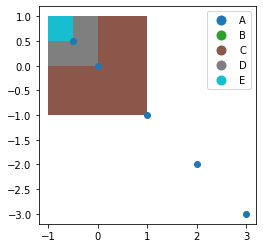

In [92]:
import geopandas as gpd
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from shapely import set_precision
from shapely.geometry import Polygon

# Test case
# Polygon is part of 4 basins, 2 of which do not have their gauge in this polygon
polygon_A_B_C = Polygon([(-1, -1),   ( 1,  -1),   ( 1,   1), (-1, 1), (-1, -1)])  # Same polygon for A, B, C
polygon_D     = Polygon([  (-1,  0),   ( 0,   0),   ( 0,   1), (-1, 1), (-1,  0)])  # In the upper left corner of A/B/C
polygon_E     = Polygon([  (-1,  0.5), (-0.5, 0.5), (-0.5, 1), (-1, 1), (-1,  0.5)])  # In the upper left corner of D

gdf_test_basin = gpd.GeoDataFrame({
    'basin_id': ['A', 'B', 'C', 'D', 'E'],
    'unitarea': [10, 10, 10, 3, 1],
    'geometry': [polygon_A_B_C, polygon_A_B_C, polygon_A_B_C, polygon_D, polygon_E]
})

# Associated stations
gdf_test_gauge = gpd.GeoDataFrame(geometry=[Point(3, -3), Point(2, -2), Point(1, -1), Point(0, 0), Point(-0.5, 0.5)], 
                                  index=['basin_A', 'basin_B', 'basin_C', 'basin_D', 'basin_E'])

# Overview
print(gdf_test_basin)
print(gdf_test_gauge)

fig,ax = plt.subplots(1,1)
gdf_test_basin.plot(ax=ax, column='basin_id', legend=True)
gdf_test_gauge.plot(ax=ax, legend=True)

In [93]:
gdf_subset = gdf_test_basin # so we can re-use the names in the real code
tmp_stations = gdf_test_gauge

In [94]:
# 4. Identify in how many parts we need to split this
# I.e., in cases where the full river basin contains more than 1 nested gauge,
#  a polygon may appear in three or more CAMELS-SPAT basins, but the polygon
#  itself may only contain one of the multiple nested gauges in the larger
#  river basin. 
# 
# 4a. We can use the unique 'unitarea' values to figure out in how
#  many parts we need to split this, but we may need to be wary of rounding
#  precision.
tolerance = 6 # decimal places, because unitarea is in km^2 this effectively
              # means we consider areas equivalent if they are within m^2 of
              # one another
num_parts = gdf_subset['unitarea'].round(tolerance).nunique()

# 4b. We can also get this directly from the station locations:
# Check how many of our station location fall inside the first polygon:
#  because we sorted the geodataframe this should be the whole thing.
# NOTE: this will return falls for stations that are exactly ON the polygon edge,
#       only stations IN the polygon are counted
station_in_poly_mask = gdf_subset.iloc[0]['geometry'].contains(tmp_stations)
num_parts_from_station = station_in_poly_mask.sum()[0]+1 # +1, because two stations divide the poly in three parts

# 4c. Confirm both numbers are the same
assert num_parts == num_parts_from_station, "Different number of parts to split polygon into returned by different approaches"

In [95]:
# 5. Split the polygons into parts
new_parts = []
new_comids = []
max_ix = len(gdf_subset)-1 # length (e.g. 4) means indexing stops at 3
part_id = 0 # we'll use this to number the new polygon parts
for ix,row in gdf_subset.iterrows():
    
    # Handle special case: most upstream, smallest (because we sorted this way), polygon
    if ix == max_ix: 
        new_parts.append(gdf_subset['geometry'].iloc[ix]) # We can simply add this because it already exist as the final part
        part_id += 1 # we've created a new part so increment by 1
        new_comids.append(f"{comid}_{part_id}")

    # Rest
    else: 
        # Check if we're dealing with the case of: multiple nested gauges in the basin, but not the polygon
        if gdf_subset['unitarea'].iloc[ix].round(tolerance) == gdf_subset['unitarea'].iloc[ix+1].round(tolerance):
            new_parts.append('no-split')
            new_comids.append(f"{comid}_{part_id}")
            
        # Or if we're at the point where we're dealing with nested gauge(s) in this specific polygon
        else:
            new_parts.append(gdf_subset['geometry'].iloc[ix].difference(gdf_subset['geometry'].iloc[ix+1])) # new poly
            part_id += 1 # we've created a new part so increment by 1   
            new_comids.append(f"{comid}_{part_id}")

In [96]:
new_parts, new_comids

(['no-split',
  'no-split',
  <POLYGON ((1 1, 1 -1, -1 -1, -1 0, 0 0, 0 1, 1 1))>,
  <POLYGON ((0 1, 0 0, -1 0, -1 0.5, -0.5 0.5, -0.5 1, 0 1))>,
  <POLYGON ((-1 0.5, -0.5 0.5, -0.5 1, -1 1, -1 0.5))>],
 ['83020078_0', '83020078_0', '83020078_1', '83020078_2', '83020078_3'])

In [97]:
# --- Clean up any unsightly tendrils resulting from the differencing
# Settings
precision = 1e-08 # Define the precision level
area_tol = 1e-5 # tolerance % for accepted changes

# Loop over the new parts we just created
updated_parts = []
for new_part in new_parts: # Gives either 'no-split' or a geometry
    
    # Skip the ones we haven't filled yet (this will come later, after fixing the ones we do have)
    if new_part == 'no-split':
        updated_parts.append(new_part)
        continue # to next new_part

    # Create the simplified geometry
    precise_geom = set_precision(new_part,precision)

    # Run the area check
    area_ratio = precise_geom.area / new_part.area
    assert abs(area_ratio - 1) <= area_tol, f"area ratio outside tolerance {area_tol}"

    # Retain the new geometry
    updated_parts.append(precise_geom)

# Replace
new_parts = updated_parts

In [98]:
# Now, if any 'no-split's are present, fill them with the polygon immediately below because these should be the same ones
num_entries = len(new_parts)
for i in range(num_entries): # check every list entry
    if new_parts[i] == 'no-split': # find the first valid polygon and replace
        for j in range(i+1, num_entries):
            if new_parts[j] != 'no-split': # if not no-split, must be (multi)poly
                new_parts[i] = new_parts[j]
                new_comids[i] = new_comids[j]
                break # critical, because otherwise it'll keep going until the last one

In [99]:
new_parts, new_comids

([<POLYGON ((1 -1, -1 -1, -1 0, 0 0, 0 1, 1 1, 1 -1))>,
  <POLYGON ((1 -1, -1 -1, -1 0, 0 0, 0 1, 1 1, 1 -1))>,
  <POLYGON ((1 -1, -1 -1, -1 0, 0 0, 0 1, 1 1, 1 -1))>,
  <POLYGON ((0 0, -1 0, -1 0.5, -0.5 0.5, -0.5 1, 0 1, 0 0))>,
  <POLYGON ((-1 1, -0.5 1, -0.5 0.5, -1 0.5, -1 1))>],
 ['83020078_1', '83020078_1', '83020078_1', '83020078_2', '83020078_3'])

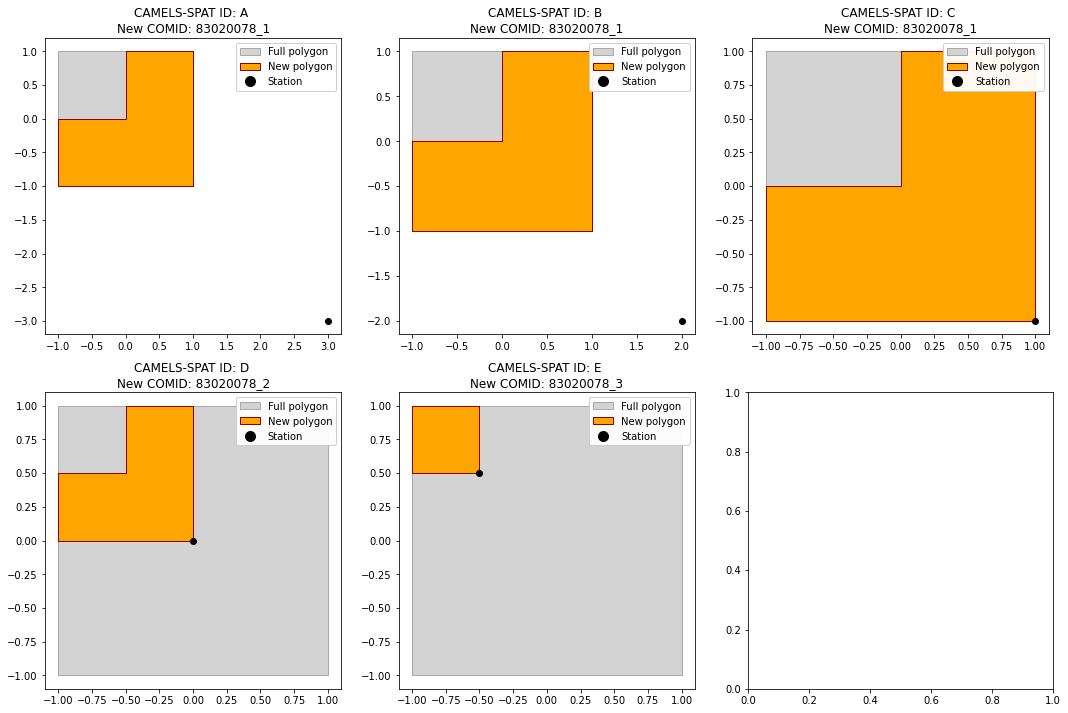

In [100]:
# Plotting code to check the outcomes
fig, axs = plt.subplots(2,3,figsize=(15,10))
axs = axs.flatten()
for ix in range(len(gdf_subset)):
    ax = axs[ix]
    ax.set_title(f"CAMELS-SPAT ID: {gdf_subset.iloc[ix]['basin_id']} \nNew COMID: {new_comids[ix]}")
    gpd.GeoSeries(gdf_subset.iloc[0].geometry).plot(ax=ax, color='lightgrey', edgecolor='darkgrey')
    gpd.GeoSeries(new_parts[ix]).plot(ax=ax, color='orange', edgecolor='darkred')
    ax.plot(tmp_stations.iloc[ix]['geometry'].x,tmp_stations.iloc[ix]['geometry'].y, marker='o', color='k')
    # legend
    old_patch = Patch(facecolor='lightgrey', edgecolor='darkgrey', label='Full polygon')
    new_patch = Patch(facecolor='orange', edgecolor='darkred', label='New polygon')
    station = mlines.Line2D([], [], color='k', marker='o', linestyle='None', markersize=10, label='Station')
    ax.legend(handles=[old_patch, new_patch, station], loc='best', framealpha=0.95)

plt.tight_layout()

### Investigate potential basin issue
This work has uncovered a case where, due to quirks in the MERIT Hydro DEM, two independent gauges have ended up covering identical basins. Here we plot the situation to invetigate what's going on.

In [17]:
from shapely import Point
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) # warning off: doesn't matter here

In [18]:
# Gauge IDs
basins = ['CAN_08AA007','CAN_08AA008']

In [19]:
# Load the data
ref_shapes = []
dis_shapes = []
riv_shapes = []
station_locs = []
outlet_locs = []
mapped_locs = []
for basin_str in basins:
    
    # Construct the path to the shapefiles
    dist_shp_basin = basin_path / basin_str / 'shapefiles' / 'distributed' / (basin_str + '_distributed_basin.shp')
    dist_shp_river = basin_path / basin_str / 'shapefiles' / 'distributed' / (basin_str + '_distributed_river.shp')
    refr_shp_basin  = basin_path / basin_str / 'shapefiles' / 'reference'  / (basin_str + '_reference.shp')
    
    # Open the shapes
    dis_shapes.append(gpd.read_file(dist_shp_basin))
    riv_shapes.append(gpd.read_file(dist_shp_river))
    ref_shapes.append(gpd.read_file(refr_shp_basin))

    # Extract actual and resulting station location
    meta_mask = ((cs_meta['Country'] == basin_str[0:3]) & (cs_meta['Station_id'] == basin_str[4:]))
    station_locs.append(Point(cs_meta[meta_mask]['Station_lon'],cs_meta[meta_mask]['Station_lat']))
    outlet_locs.append(Point(cs_meta[meta_mask]['Outlet_lon'],cs_meta[meta_mask]['Outlet_lat']))
    mapped_locs.append(Point(cs_meta[meta_mask]['Mapped_lon'],cs_meta[meta_mask]['Mapped_lat']))

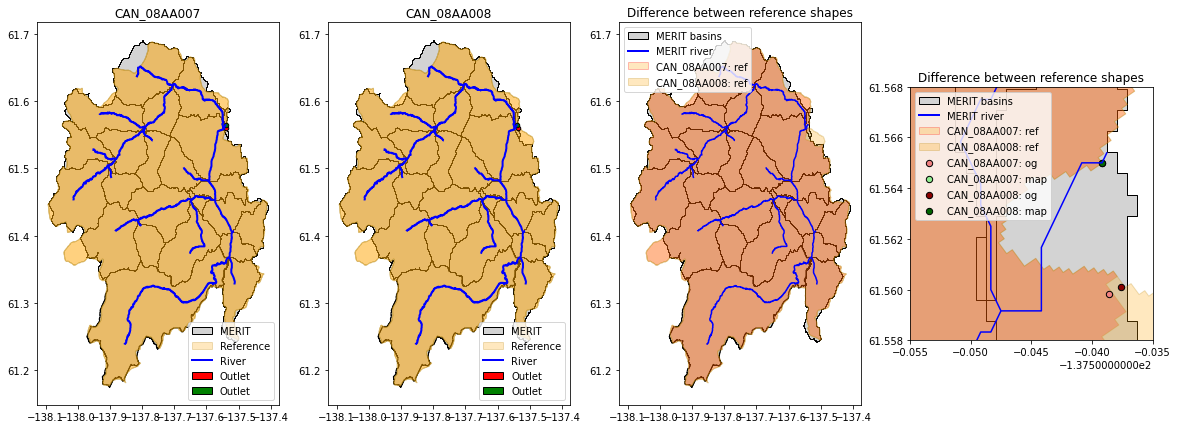

In [36]:
fig,axs = plt.subplots(1,4,figsize=(20,8))

def plot_basin(i,ax):
    dis_shapes[i].plot(ax=ax, edgecolor='k', facecolor='lightgrey')
    riv_shapes[i].plot(ax=ax, linewidth=2, edgecolor='blue')
    ref_shapes[i].plot(ax=ax, edgecolor='darkgoldenrod', facecolor='orange', alpha=0.5)
    ax.scatter(outlet_locs[i].x, outlet_locs[i].y, 20, color='red', edgecolor='k', label="Outlet")
    ax.scatter(mapped_locs[i].x, mapped_locs[i].y, 20, color='green', edgecolor='k', label="Map-to-MERIT")
    
    merit_patch = Patch(facecolor='lightgrey', edgecolor='k', label='MERIT')
    reference_patch = Patch(facecolor='orange', edgecolor='darkgoldenrod', alpha=0.25, label='Reference')
    river_line = Line2D([0], [0], color='blue', lw=2, label='River')
    outlet_patch = Patch(facecolor='red', edgecolor='k', label='Outlet')
    mapped_patch = Patch(facecolor='green', edgecolor='k', label='Outlet')
    ax.legend(handles=[merit_patch, reference_patch, river_line,outlet_patch,mapped_patch], loc='lower right')
    ax.set_title(f"{basins[i]}")
    return

def plot_ref_comarison(ax,plot_gauges=False):
    dis_shapes[0].plot(ax=ax, edgecolor='k', facecolor='lightgrey')
    ref_shapes[0].plot(ax=ax, edgecolor='darkgoldenrod', facecolor='red', alpha=0.25)
    ref_shapes[1].plot(ax=ax, edgecolor='darkgoldenrod', facecolor='orange', alpha=0.25)
    riv_shapes[0].plot(ax=ax, edgecolor='blue')
    merit_patch = Patch(facecolor='lightgrey', edgecolor='k', label='MERIT basins')
    reference_patch1 = Patch(facecolor='orange', edgecolor='red', alpha=0.25, label=f"{basins[0]}: ref")
    reference_patch2 = Patch(facecolor='orange', edgecolor='darkgoldenrod', alpha=0.25, label=f"{basins[1]}: ref")
    river_line = Line2D([0], [0], color='blue', lw=2, label='MERIT river')
    handles = [merit_patch, river_line, reference_patch1, reference_patch2]
    if plot_gauges:
        h1 = ax.scatter(outlet_locs[0].x, outlet_locs[0].y, 40, color='lightcoral', edgecolor='k', label=f"{basins[0]}: og")
        h2 = ax.scatter(mapped_locs[0].x, mapped_locs[0].y, 40, color='lightgreen', edgecolor='k', label=f"{basins[0]}: map")
        h3 = ax.scatter(outlet_locs[1].x, outlet_locs[1].y, 40, color='darkred', edgecolor='k', label=f"{basins[1]}: og")
        h4 = ax.scatter(mapped_locs[1].x, mapped_locs[1].y, 40, color='darkgreen', edgecolor='k', label=f"{basins[1]}: map")
        handles.append(h1)
        handles.append(h2)
        handles.append(h3)
        handles.append(h4)
        ax.set_xlim([-137.555,-137.535])
        ax.set_ylim([61.558,61.568])

    ax.legend(handles=handles, loc='upper left')
    ax.set_title('Difference between reference shapes')
    return

plot_basin(0,axs[0])
plot_basin(1,axs[1])
plot_ref_comarison(axs[2], plot_gauges=False)
plot_ref_comarison(axs[3], plot_gauges=True)

In [47]:
for basin in basins:
    meta_mask = ((cs_meta['Country'] == basin[0:3]) & (cs_meta['Station_id'] == basin[4:]))
    for column in ['Ref_and_new_shape_fractional_overlap', 'Manual_delineation_notes', 'Delineation_confidence', 'Delineation_notes']:
        print(f"Basin {basin}, {column}: {cs_meta[meta_mask][column].values[0]}")

Basin CAN_08AA007, Ref_and_new_shape_fractional_overlap: 0.974550667
Basin CAN_08AA007, Manual_delineation_notes: nan
Basin CAN_08AA007, Delineation_confidence: high
Basin CAN_08AA007, Delineation_notes: nan
Basin CAN_08AA008, Ref_and_new_shape_fractional_overlap: 0.973630495
Basin CAN_08AA008, Manual_delineation_notes: nan
Basin CAN_08AA008, Delineation_confidence: high
Basin CAN_08AA008, Delineation_notes: nan


Summary: the DEM is likely not any good, but because the fractional overlap is still really high (> 97%) this escaped notice before.

However, `CAN_08AA007` has already been listed as an unusable basin because no flow observations are available here. No further action needed.

### River split plotting dev code
Keeping this here in case I need it later. 

In [ ]:
fig,axs = plt.subplots(2,2, figsize=(12,8))

# old river basin 1
ax = axs[0,0]
new_gdf.plot(ax=ax, color='None', edgecolor='darkgrey')
gpd.GeoSeries(new_gdf.iloc[0].geometry).plot(ax=ax, color='None', edgecolor='black', linewidth=2)
gpd.GeoSeries(segment_gdf.iloc[1].geometry).plot(ax=ax, color='blue', linewidth=2)

new_basin = mlines.Line2D([], [], color='k', label='New outline')
old_river = mlines.Line2D([], [], color='blue', label='Old river')
ax.legend(handles=[new_basin, old_river], loc='upper left', framealpha=0.95)
ax.set_title(new_gdf.iloc[0].basin_id)

# old river basin 2
ax = axs[0,1]
new_gdf.plot(ax=ax, color='None', edgecolor='darkgrey')
gpd.GeoSeries(new_gdf.iloc[1].geometry).plot(ax=ax, color='None', edgecolor='black', linewidth=2)
gpd.GeoSeries(segment_gdf.iloc[0].geometry).plot(ax=ax, color='blue', linewidth=2)

new_basin = mlines.Line2D([], [], color='k', label='New outline')
old_river = mlines.Line2D([], [], color='blue', label='Old river')
ax.legend(handles=[new_basin, old_river], loc='upper left', framealpha=0.95)
ax.set_title(new_gdf.iloc[1].basin_id)

# new river basin 1
ax = axs[1,0]
new_gdf.plot(ax=ax, color='None', edgecolor='darkgrey')
gpd.GeoSeries(new_gdf.iloc[0].geometry).plot(ax=ax, color='None', edgecolor='black', linewidth=2)
gpd.GeoSeries(new_segments.iloc[0].geometry).plot(ax=ax, color='blue', linewidth=2)

new_basin = mlines.Line2D([], [], color='k', label='New outline')
old_river = mlines.Line2D([], [], color='blue', label='New river')
ax.legend(handles=[new_basin, old_river], loc='upper left', framealpha=0.95)
ax.set_title(new_gdf.iloc[0].basin_id)

# new river basin 2s
ax = axs[1,1]
new_gdf.plot(ax=ax, color='None', edgecolor='darkgrey')
gpd.GeoSeries(new_gdf.iloc[1].geometry).plot(ax=ax, color='None', edgecolor='black', linewidth=2)
gpd.GeoSeries(new_segments.iloc[1].geometry).plot(ax=ax, color='blue', linewidth=2)

new_basin = mlines.Line2D([], [], color='k', label='New outline')
old_river = mlines.Line2D([], [], color='blue', label='New river')
ax.legend(handles=[new_basin, old_river], loc='upper left', framealpha=0.95)
ax.set_title(new_gdf.iloc[1].basin_id)

#### Check nested gauges for Jim Kirchner

In [203]:
# Load the attributes
cs_attributes = pd.read_csv(cs_meta_path / 'camels_spat_attributes.csv', low_memory=False)

In [215]:
# Select the few rows we want
elev_row = cs_attributes[cs_attributes['Attribute'] == 'elev_mean']
frac_snow1_row = cs_attributes[cs_attributes['Attribute'] == 'fracsnow1_mean']
frac_snow2_row = cs_attributes[cs_attributes['Attribute'] == 'fracsnow2_mean']

In [249]:
gauges_part_of_nested_structure

Index(['CAN_06DA001', 'CAN_06DA002', 'CAN_06DA004', 'CAN_06DA005',
       'CAN_06BD001', 'CAN_06CD002', 'CAN_04AB001', 'CAN_04AD002',
       'CAN_06BB003', 'CAN_06BB005',
       ...
       'CAN_10PB001', 'CAN_10RA001', 'CAN_10RC001', 'CAN_10RA002',
       'CAN_06JC002', 'CAN_06MA006', 'CAN_06KC003', 'CAN_06JB001',
       'CAN_06LA001', 'CAN_06LC001'],
      dtype='object', name='basin_id', length=552)

In [260]:
# find unique gauges in the list
gauges_part_of_nested_structure = duplicate_comids_with_gauge.index.get_level_values(1).unique()

# Initialize the data structures we need to store things
nested_set = 0 
nest_ids = []
countries = []
gauge_ids = []
gauge_lats = []
gauge_lons = []
areas = []
elevations = []
temporal_snow_fracs = []
spatial_snow_fracs = []
processed_gauges = []

# loop over each gauge and find the COMIDs this gauge appears in
# The COMIDs are specific polygons where another gauge is and can thus be used to find nested structures
for gauge in gauges_part_of_nested_structure:

    # Check if we have already processed this gauge as part of an earlier gauge's nested basins
    if gauge in processed_gauges:
        continue       

    # If not, check which COMIDs this gauge appears in
    comids = duplicate_comids_with_gauge.xs(gauge, level='basin_id').index.unique()
    
    # Now loop over the COMIDs and select the row in the original GDF that has the most gauges in it,
    # This is the polygon of the uppermost gauge in the whole nested set
    lengths = []
    for comid in comids:
        tmp_selection = duplicate_comids_with_gauge.xs(comid, level='COMID')
        lengths.append(len(tmp_selection))
    most_upstream_comid = comids[np.array(lengths).argmax()]
    tmp_selection = duplicate_comids_with_gauge.xs(most_upstream_comid, level='COMID')

    # Now prep the new dataframe for Jim
    nested_set += 1
    for gauge_id in tmp_selection.index:

        # store that we dealt with this one already
        processed_gauges.append(gauge_id)

        # select the metadata row
        country = gauge_id.split('_')[0]
        station = gauge_id.split('_')[1]
        meta_row = cs_meta[cs_meta['Station_id'] == station]

        # append the info
        nest_ids.append(nested_set)
        countries.append(country)
        gauge_ids.append(station)
        gauge_lats.append(meta_row['Station_lat'].values[0])
        gauge_lons.append(meta_row['Station_lat'].values[0])
        areas.append(meta_row['Basin_area_km2'].values[0])

        # select the attribute row
        if gauge_id in elev_row.columns:
            elevations.append(elev_row[gauge_id].values[0])
            temporal_snow_fracs.append(frac_snow1_row[gauge_id].values[0])
            spatial_snow_fracs.append(frac_snow2_row[gauge_id].values[0])
        else:
            elevations.append(-999)
            temporal_snow_fracs.append(-999)
            spatial_snow_fracs.append(-999)

In [261]:
# Create a new dataframe for saving
nested_basins = pd.DataFrame({'set of nested gauges': nest_ids,
                              'gauge ID': gauge_ids,
                              'country': countries,
                              'gauge lat': gauge_lats,
                              'gauge_lon': gauge_lons,
                              'basin area (km2)': areas,
                              'mean elevation (masl)': elevations,
                              'fraction snow estimate 1': temporal_snow_fracs,
                              'fraction snow estimate 2': spatial_snow_fracs})

In [262]:
# Save
nested_basins.to_csv(cs_meta_path / 'nested_gauges.csv', index=False)

### Backups

In [ ]:
'''
2024-11-06: updated code to handle cases where one of the nested gauges is not on the river network

def split_river_segment(comid, new_basins, rivers_gdf):

    # 1. Select the correct subset
    segment_mask = rivers_gdf.index.get_level_values(0) == comid
    segment_gdf = rivers_gdf[segment_mask]
    if not len(segment_gdf) > 0:
        print(f"!!! WARNING: No river segments found for COMID {comid}. Returning error codes.")
        return -1,-1

    # 2. Perform a bunch of checks to ensure we've got this right
    segment_comid = segment_gdf.index.get_level_values(0).unique()[0]
    basins_comid = int(new_basins['new_COMID'][0].split('_')[0]) # just the first 
    assert segment_comid == basins_comid, "COMID mismatch between selected river subset and new basin geodataframe"
    
    segment_stations = segment_gdf.index.get_level_values(1).values
    basins_stations = new_basins['basin_id'].values
    assert sorted(segment_stations) == sorted(basins_stations), "different station IDs detected in newly-split basins gdf and associated river segment gdf"
    
    geometries_intersect = [g1.intersects(g2) for g1 in segment_gdf.geometry for g2 in new_basins.geometry]
    assert any(geometries_intersect), "no intersecting geometries in newly-split gdf and associated river segment gdf"

    # 3. Find the longest river segment
    ea_gdf = segment_gdf.to_crs(area_crs)
    ea_gdf['length'] = ea_gdf['geometry'].length / 1000
    longest_idx = ea_gdf['length'].idxmax()
    longest_segment = segment_gdf.loc[longest_idx]['geometry'] # This is the one we need to split

    # 4. Split accordingly
    basin_ids  = [] 
    new_comids = []
    new_parts  = [] # Geometries
    new_down= [] # NextDownID
    new_up1 = [] # Upstream IDs
    new_up2 = []
    new_up3 = []
    new_up4 = []

    for basin_ix,basin_row in new_basins.iterrows():
    
        # matching row in the segment gdf
        segment_row = segment_gdf.xs(basin_row.basin_id, level='basin_id')

        # identifiers
        basin_ids.append(basin_row.basin_id)
        new_comids.append(basin_row.new_COMID)
        
        # Compare this 'new_COMID' against the next one.
        # If it's the same, we're dealing with a case of multiple downstream gauges sharing this polygon.
        # In such cases we can't do anything yet, and we need to fill these fields later.
        if (basin_ix < len(new_basins)-1) and new_basins['new_COMID'].iloc[basin_ix+1] == basin_row.new_COMID:
            new_down.append('no-split') # downstream segment ID
            new_up1.append('no-split') # upstream IDs
            new_up2.append('no-split')
            new_up3.append('no-split')
            new_up4.append('no-split')
            new_parts.append('no-split') # geometry

        # If the 'new_COMID's do not match, we need to move to the splitting code.
        # This can be the first polygon, or any later ones so all the splitting code needs to be here.
        else:

            # downstream segment ID
            if basin_ix == 0:       
                new_down.append(str(segment_row.NextDownID.values[0])) # we're doing these from most downstream to upstream basin, so for the first one we keep the current NextDownID
            else:
                new_down.append(new_comids[basin_ix-1]) # for all others (unless we're in a special case - these need to be handled separately), keep the new_comid of previous basin
        
            # upstream IDs
            if basin_ix < len(new_basins)-1: # i.e., not the last basin we're looking at (len()-1 because we start indexing at 0; i.e. for length = 2, the last index we'll get is 1)
                new_up1.append(new_basins.iloc[basin_ix+1]['new_COMID']) # this works because we only do this until the second-to-last row
                new_up2.append(0)
                new_up3.append(0)
                new_up4.append(0)
            else: # i.e., most upstream segment, and thus the end point of the original stream segment
                new_up1.append(segment_row['up1'].values[0])
                new_up2.append(segment_row['up2'].values[0])
                new_up3.append(segment_row['up3'].values[0])
                new_up4.append(segment_row['up4'].values[0])
        
            # actual geometry
            # This if-statement should find the first basin where we need to split, and we need to do it this way
            # because the river line extends a little downstream of the most downstream polygon. Without this construction
            # we cut off this most downstream part that falls outside the actual basin polygon, but should be part of this 
            # river segment.
            if (basin_ix == 0) or all(part == 'no-split' for part in new_parts):
                combined_upstream = unary_union(new_basins[basin_ix+1:]['geometry']) # works even if this selects only one polygon
                new_parts.append(longest_segment.difference(combined_upstream))
            # For non-downstream basin polygons things are simpler
            else:
                new_parts.append(longest_segment.intersection(basin_row.geometry))

    # 5. Fill the 'no-splits'
    num_entries = len(new_parts)
    for i in range(num_entries): # check every list entry
        if new_parts[i] == 'no-split': # find the first valid polygon and replace
            for j in range(i+1, num_entries):
                    if new_parts[j] != 'no-split': # if not no-split, must be (multi)poly
                        new_down[i] = new_down[j] # downstream segment ID
                        new_up1[i] = new_up1[j] # upstream IDs
                        new_up2[i] = new_up2[j]
                        new_up3[i] = new_up3[j]
                        new_up4[i] = new_up4[j]
                        new_parts[i] = new_parts[j] # geometry
                        break # critical, because otherwise it'll keep going until the last one
    
    # 6. put the whole thing back together
    new_segments = gpd.GeoDataFrame(data={'new_COMID': new_comids,
                                          'basin_id': basin_ids,
                                          'NextDownID':new_down,
                                          'up1':new_up1,
                                          'up2':new_up2,
                                          'up3':new_up3,
                                          'up4':new_up4},
                                    geometry=new_parts,
                                    crs='EPSG:4326')
    new_segments['new_len_km'] = new_segments.to_crs(area_crs).length / 1000 # [m] > [km]
    new_segments = new_segments[['new_COMID','basin_id','NextDownID','up1','up2','up3','up4','new_len_km','geometry']] # easier to debug when column order matches 'gdf'

    # 7. Ensure we did not lose/create extra river
    old_length = segment_gdf['new_len_km'].max()
    new_length = new_segments.groupby('new_COMID').first()['new_len_km'].sum()
    assert np.isclose(old_length, new_length), "river length mismatch before and after segment split"
    
    return new_parts, new_segments
'''